# Modeling retinal response variability

Attempt to use simple models to show how the retina transforms a visual input into the variable responses of retinal ganglion cells.

In [54]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import h5py
from scipy.stats import zscore, norm, pearsonr, poisson
from scipy.optimize import curve_fit
from pyret.spiketools import binspikes
from pyret.filtertools import getsta, decompose
from pyret.nonlinearities import Binterp
# from deepretina.toolbox import load_model, load_partial_model, rolling_window
# from deepretina.io import despine
# from deepretina.metrics import cc
from aesthetics.plotting import adjust_spines
from os.path import expanduser

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.style.use('deepretina')

from pylab import rcParams
# rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lane/.local/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Load retinal responses to a spatiotemporal white noise stimuli

In [55]:
test_set_size = 6000
sample_rate = 100.
with h5py.File(expanduser('~/data/deep-retina-tutorial/data/whitenoise.h5'), 'r') as h:
    # train set
    whitenoise_stimulus = np.array(h['test/stimulus'][:-test_set_size])
    whitenoise_response = np.stack([np.array(h['test/repeats/%s' %key][:,:-test_set_size]) for key in sorted(h['test/repeats'].keys())])
    whitenoise_psth = np.array(h['test/response/firing_rate_10ms'][:,:-test_set_size])
    time = np.array(h['test/time'][:-test_set_size])
    
    # test set
    test_whitenoise_stimulus = np.array(h['test/stimulus'][-test_set_size:])
    test_whitenoise_response = np.stack([np.array(h['test/repeats/%s' %key][-test_set_size:]) for key in sorted(h['test/repeats'].keys())])
    test_whitenoise_psth = np.array(h['test/response/firing_rate_10ms'][:, -test_set_size:])
    test_time = np.array(h['test/time'][-test_set_size:])

In [56]:
whitenoise_stimulus.shape

(24011, 50, 50)

In [57]:
print('Each repeat is %0.1f minutes long, at a %0.1f Hz sampling rate.' %(whitenoise_stimulus.shape[0]/(sample_rate*60.), sample_rate))

Each repeat is 4.0 minutes long, at a 100.0 Hz sampling rate.


In [58]:
print(whitenoise_response.shape)
print('There are %d cells and %d repeats.' %(whitenoise_response.shape[:2]))

(28, 2, 24011)
There are 28 cells and 2 repeats.


## Visualize the data

#### First repeat of white noise

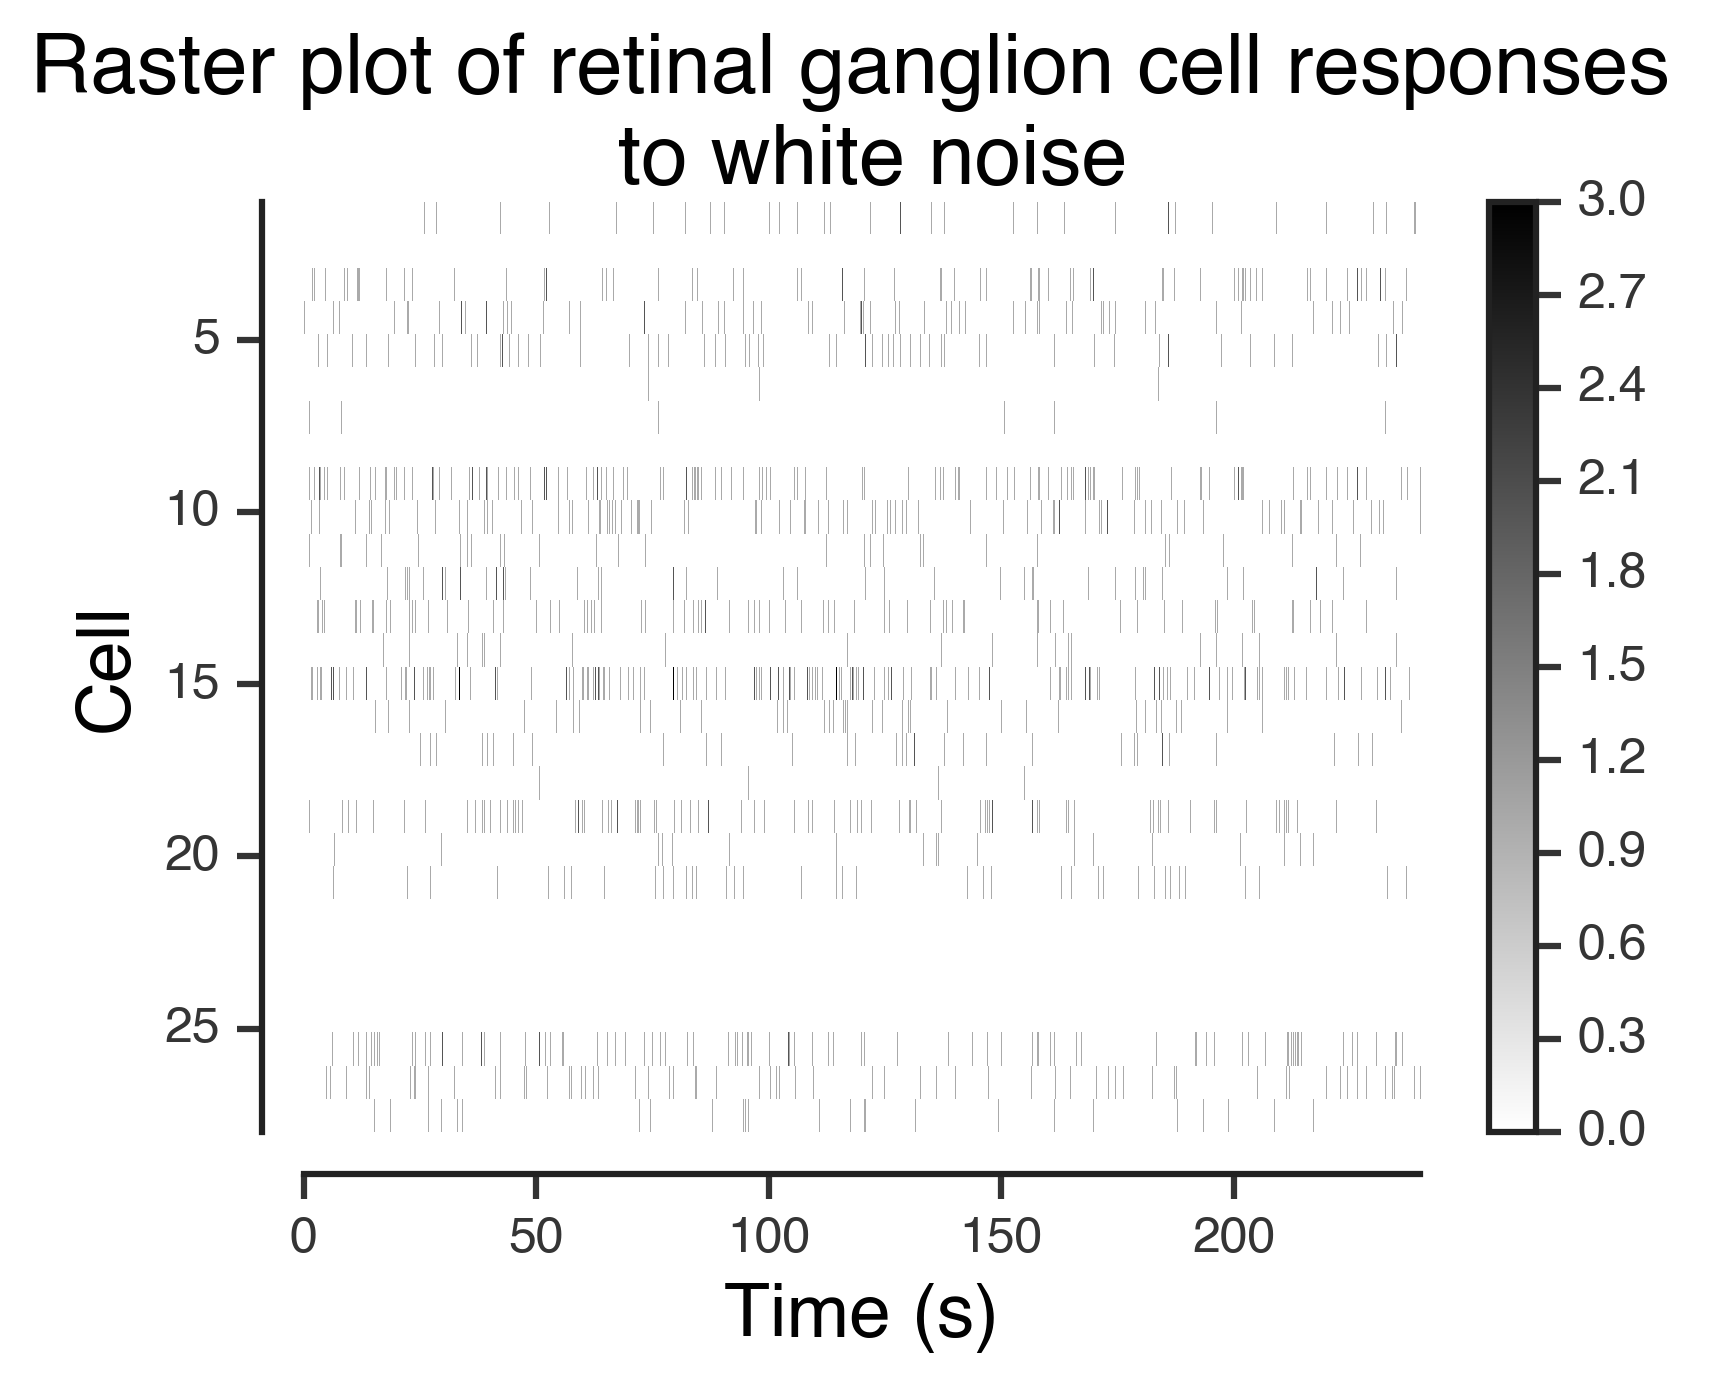

In [59]:
plt.imshow(whitenoise_response[:,0,:], aspect='auto', cmap='gray_r', extent=(time[0], time[-1], whitenoise_response.shape[0], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Cell', fontsize=18)
plt.title('Raster plot of retinal ganglion cell responses \n to white noise', fontsize=20)
plt.colorbar()
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

Which cell has the most number of spikes?

In [60]:
most_spiking_cell = np.argmax(np.sum(whitenoise_response[:,0,:], axis=1))
most_spikes = np.sum(whitenoise_response[:,0,:], axis=1)[most_spiking_cell]
print('Cell %d has the highest firing rate at %0.2f Hz' %(most_spiking_cell, 
                                                          most_spikes/(whitenoise_stimulus.shape[0]/sample_rate)))
mean_spikes = np.mean(np.sum(whitenoise_response[:,0,:], axis=1))
print('Mean spike rate is %0.2f Hz' %(mean_spikes/(whitenoise_stimulus.shape[0]/sample_rate)))

Cell 14 has the highest firing rate at 14.19 Hz
Mean spike rate is 3.75 Hz


Let's analyze what cell 14 is doing.

## Linear input-output relationship of a cell

In [61]:
spike_times = [time[t] for t,r in enumerate(whitenoise_response[most_spiking_cell,0]) if r>0]

In [62]:
# getsta takes (time, stimulus, spikes, filter_length in frames)
filter_length = 40 # at 100 Hz, 40 frames is 0.4 seconds (400 milliseconds)
zscored_stimulus = zscore(whitenoise_stimulus)
average_feature, tax = getsta(time, zscored_stimulus, spike_times, filter_length=filter_length)
average_feature.shape

(40, 50, 50)

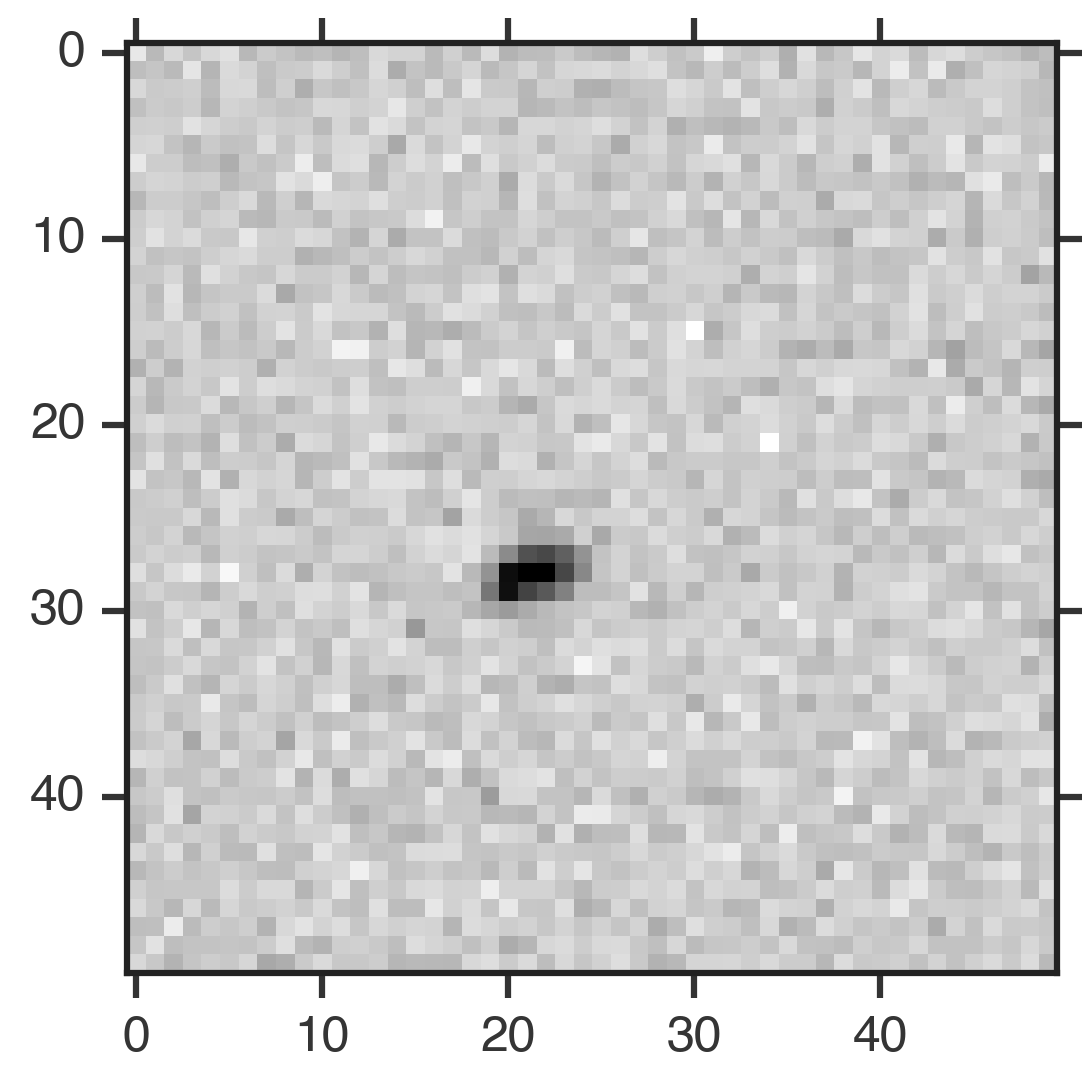

In [63]:
plt.imshow(average_feature[35])

## Decompose this 3d average feature conveyed by the cell into it's representative spatial and temporal components

In [64]:
spatial_feature, temporal_feature = decompose(average_feature)

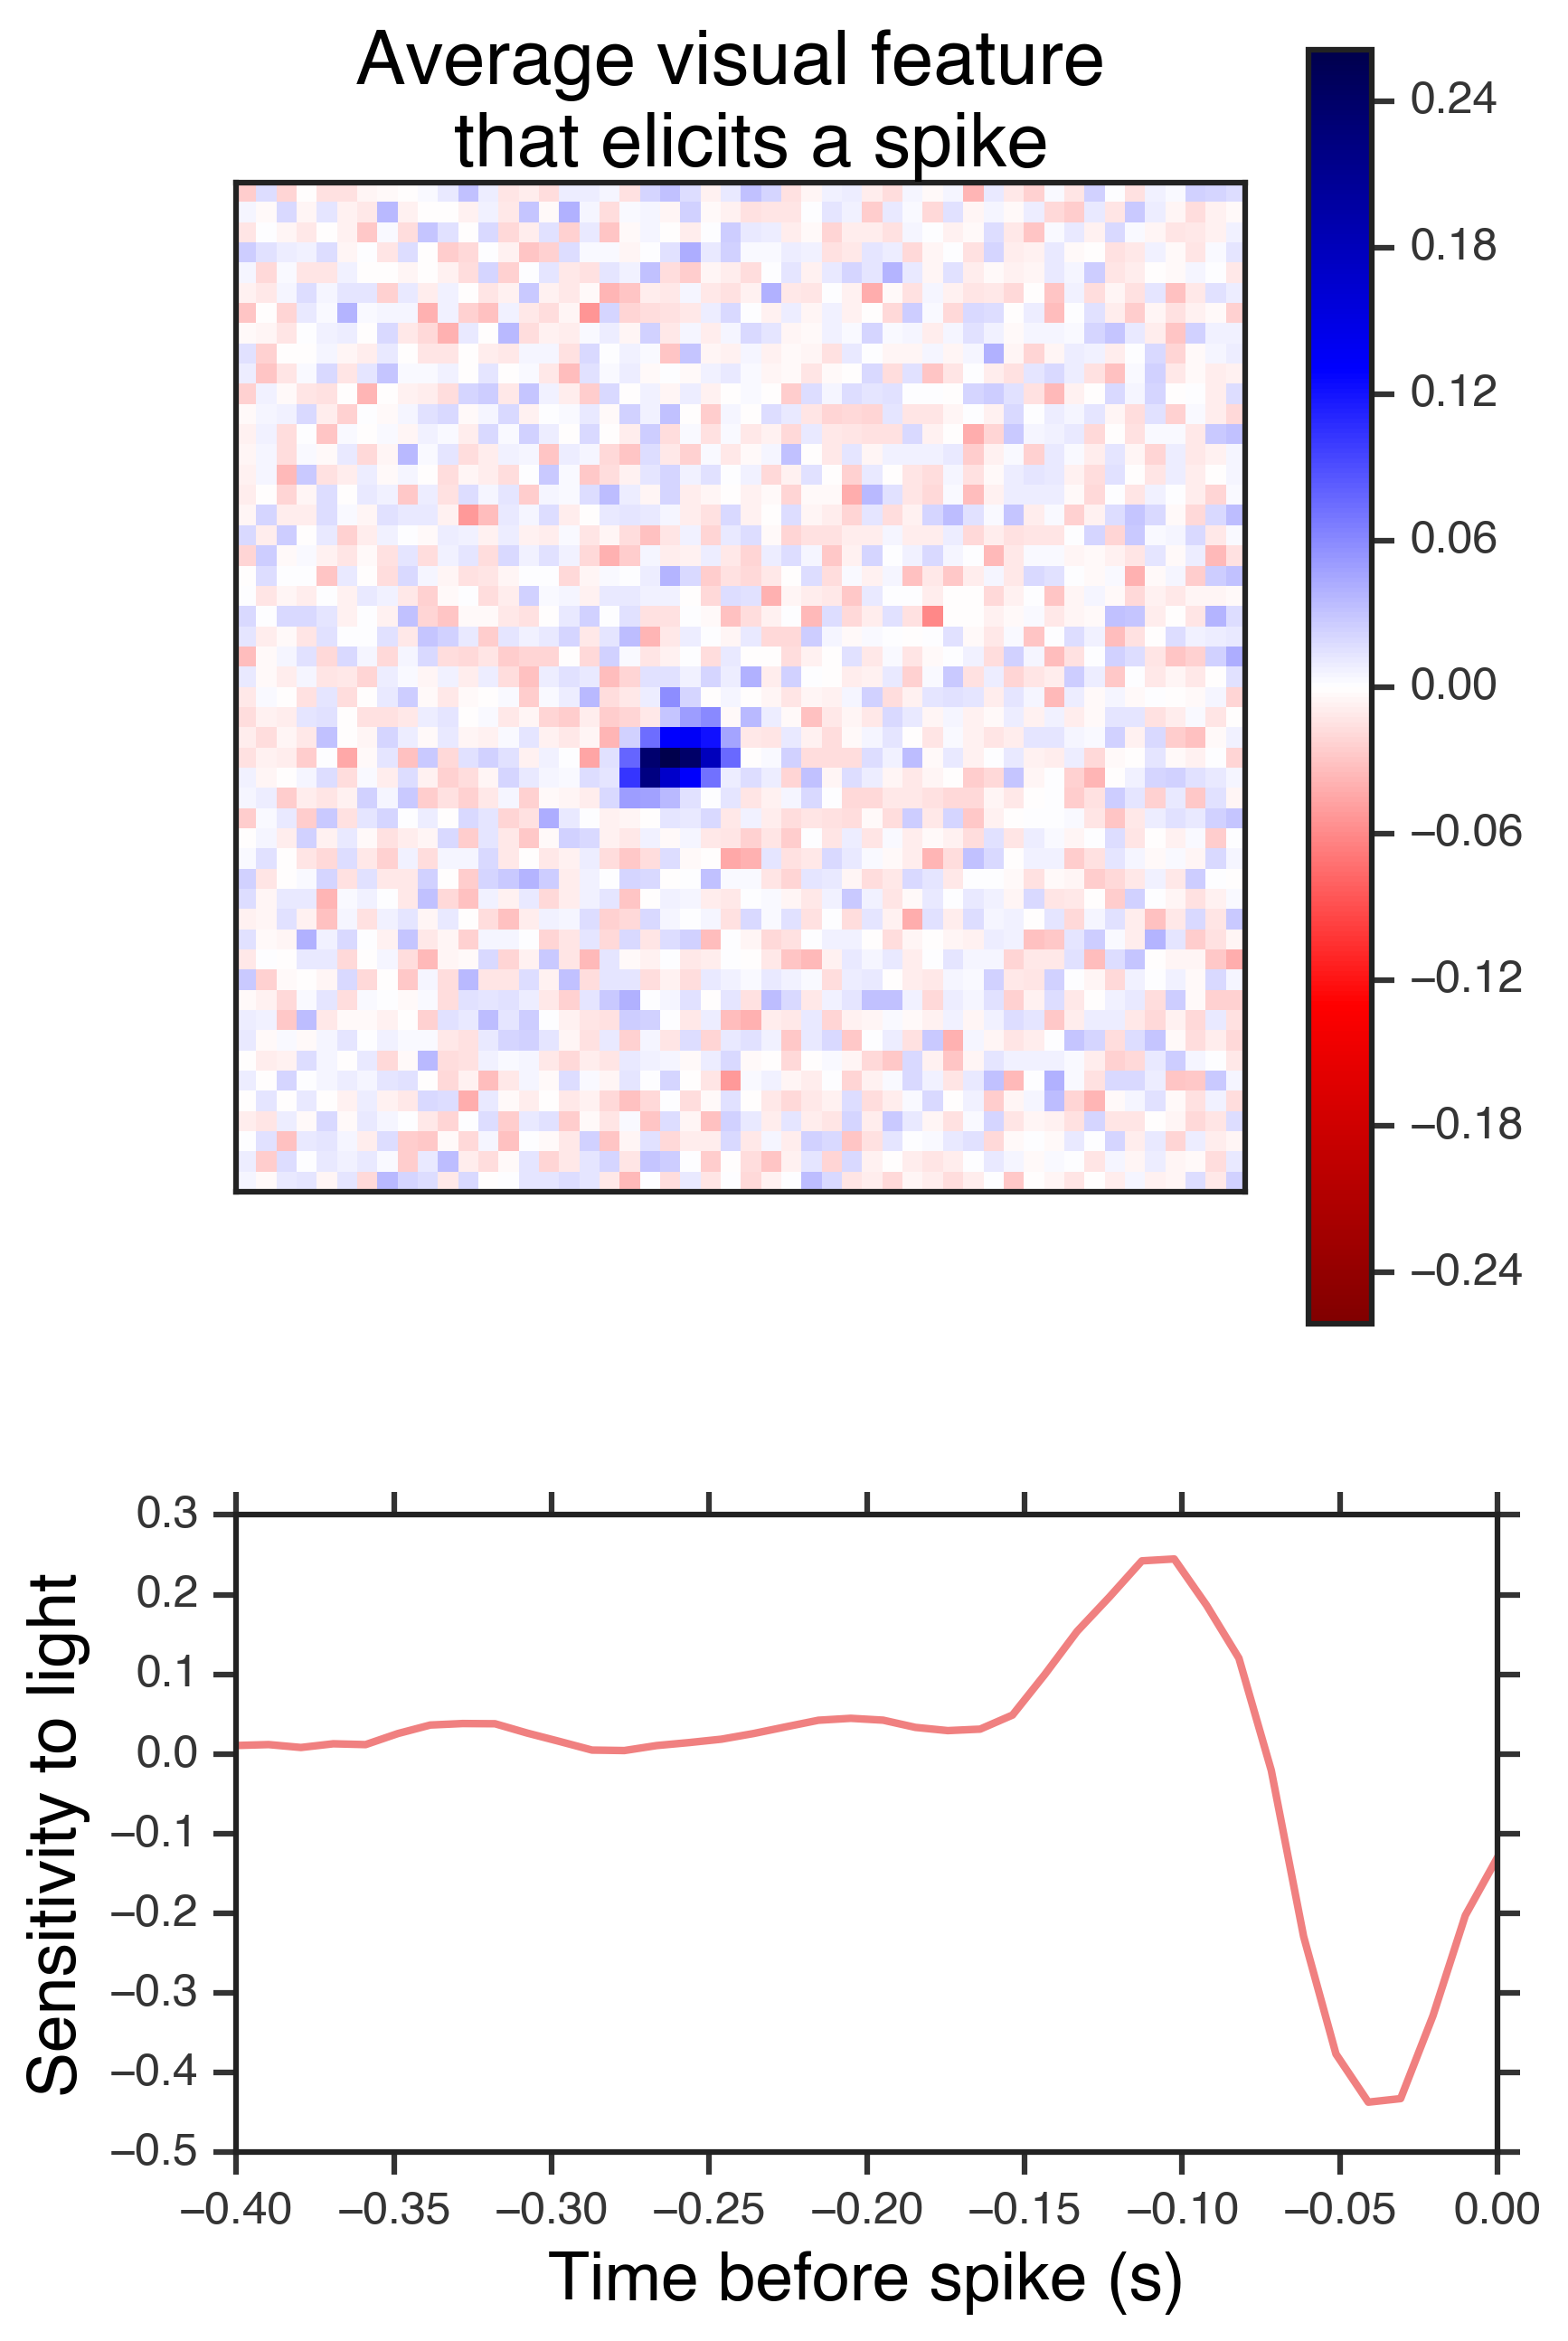

In [65]:
# plot STA
fig = plt.figure(figsize=(6,10))
filter_time = np.linspace(0.0, filter_length/sample_rate, filter_length)

# build the figure
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# plot spatial profile
ax = fig.add_subplot(gs[0])
spatial_feature -= np.mean(spatial_feature)
maxval = np.max(np.abs(spatial_feature))
img = ax.imshow(spatial_feature, cmap='seismic_r', interpolation='nearest',
        aspect='equal', vmin=-maxval, vmax=maxval)
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(img)
plt.title('Average visual feature \n that elicits a spike', fontsize=20)

# plot temporal profile
ax = fig.add_subplot(gs[1])
ax.plot(-filter_time, temporal_feature[::-1], linestyle='-', linewidth=2, color='LightCoral')
ax.set_xlim(-filter_time[-1], filter_time[0])
plt.xlabel('Time before spike (s)', fontsize=18)
plt.ylabel('Sensitivity to light', fontsize=18)

# How linear is this cell?  
# Can we plot the actual vs predicted firing rates?

Find the nonlinearity of this cell.

#### Filter the visual stimulus with our average feature to get the predicted linear response of the cell

In [66]:
zscored_stimulus.shape

(24011, 50, 50)

In [67]:
filtered_stim = np.zeros((zscored_stimulus.shape[0]-filter_length,))
for t in range(zscored_stimulus.shape[0]-filter_length):
    filtered_stim[t] = np.inner(zscored_stimulus[t:t+filter_length].flat, average_feature.flat)
    if t % 5000 == 0:
        print('Filtered %d/%d' %(t,zscored_stimulus.shape[0]-filter_length))

Filtered 0/23971
Filtered 5000/23971
Filtered 10000/23971
Filtered 15000/23971
Filtered 20000/23971


In [68]:
whitenoise_psth.shape

(28, 24011)

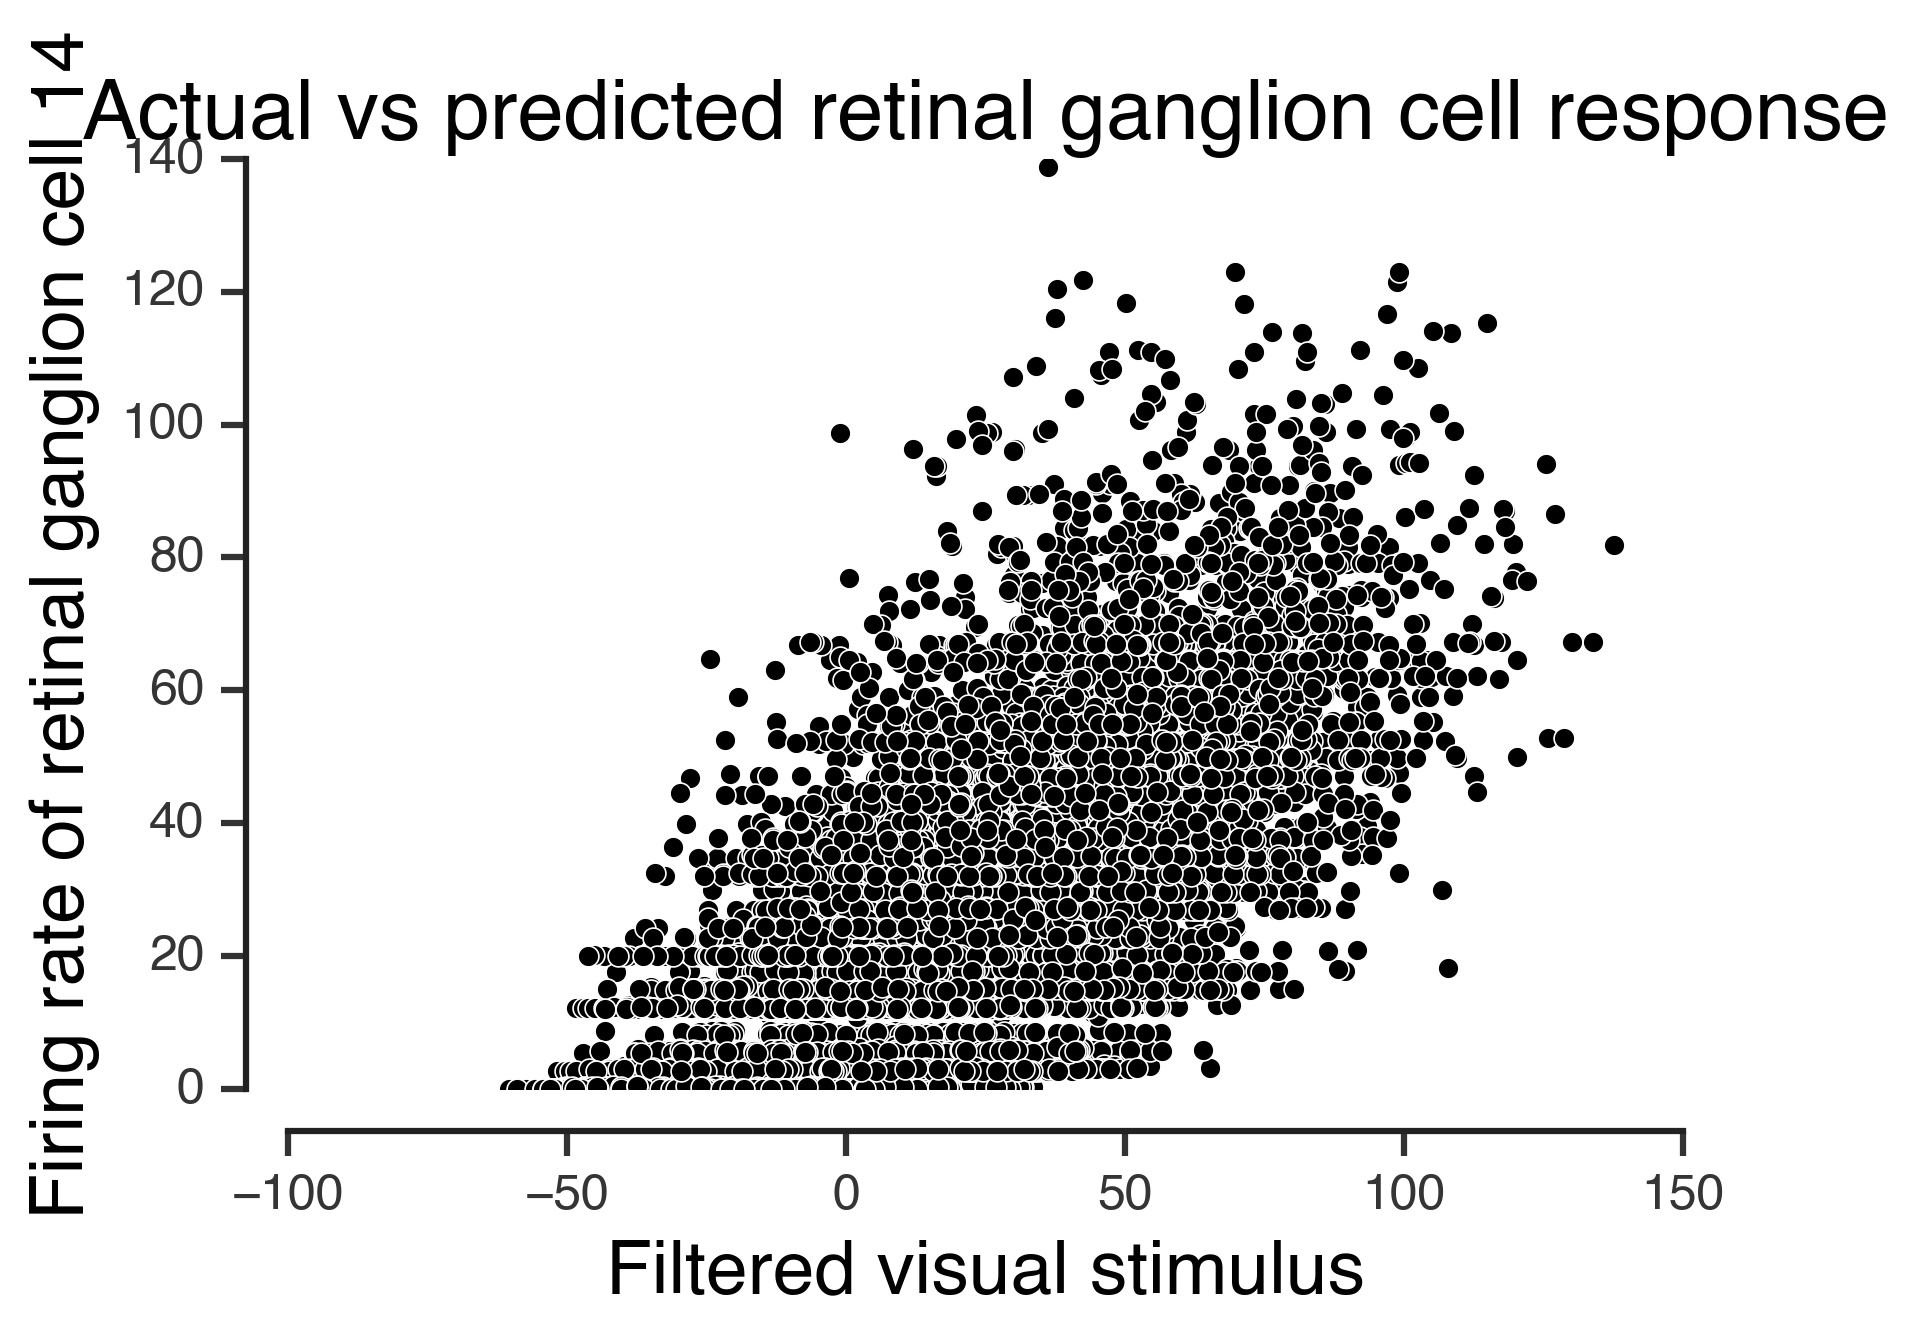

In [69]:
plt.plot(filtered_stim, whitenoise_psth[most_spiking_cell, filter_length:], 'k.', mec='w', ms=10, mew=0.4)
plt.title('Actual vs predicted retinal ganglion cell response', fontsize=20)
plt.xlabel('Filtered visual stimulus', fontsize=18)
plt.ylabel('Firing rate of retinal ganglion cell %d' %most_spiking_cell, fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Fit nonlinearity

In [70]:
# hyperparameter
nbins = 100

# fit nonlinearity
nonlinearity = Binterp(nbins, method='linear')
nonlinearity.fit(filtered_stim, whitenoise_psth[most_spiking_cell, filter_length:])

In [71]:
nonlinearity_input = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 100)
nonlinearity_output = nonlinearity.predict(nonlinearity_input)

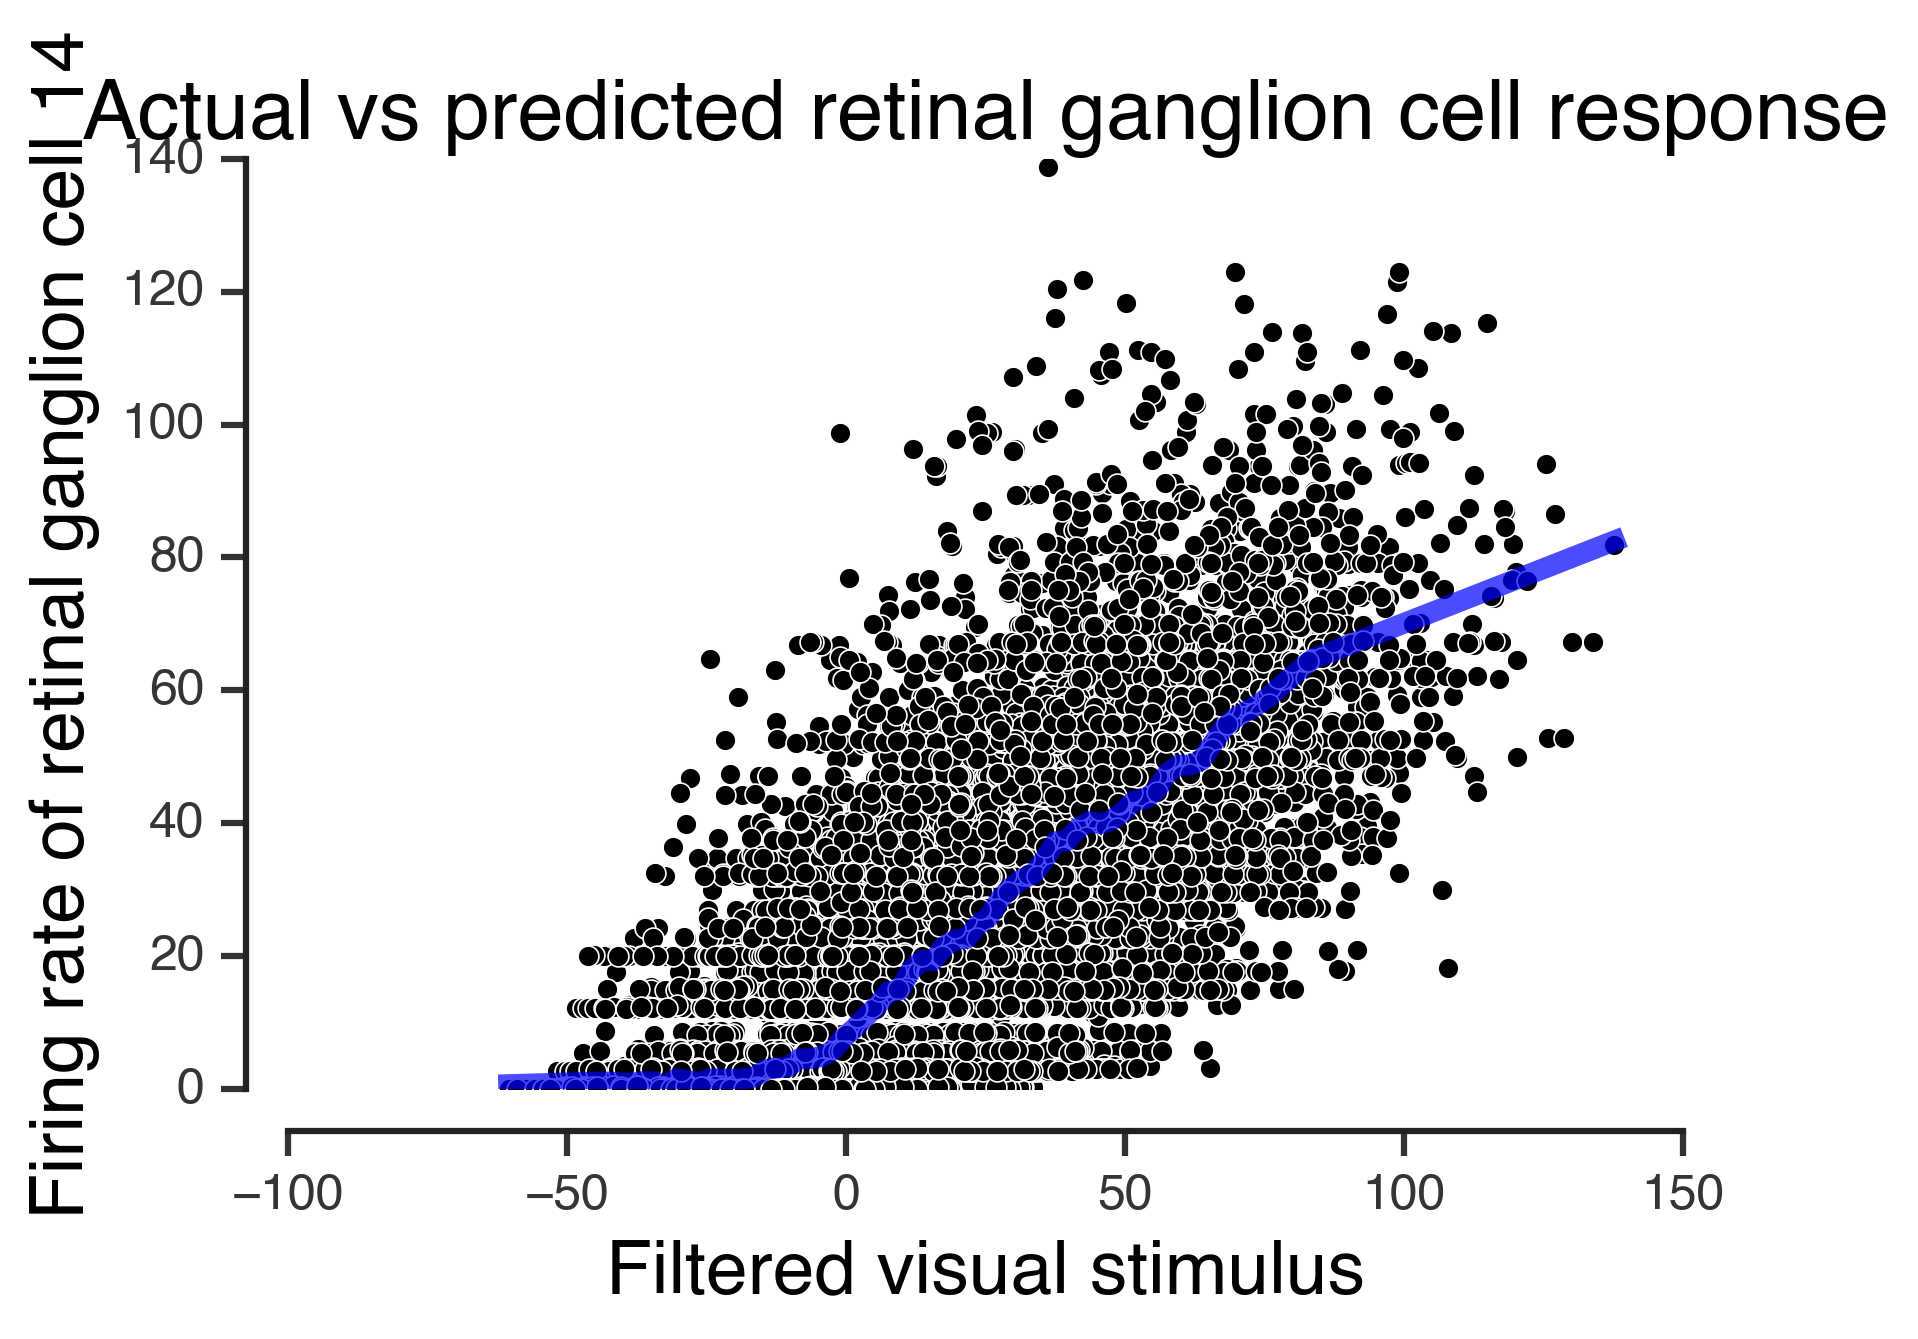

In [72]:
plt.plot(filtered_stim, whitenoise_psth[most_spiking_cell, filter_length:], 'k.', mec='w', ms=10, mew=0.4)
plt.plot(nonlinearity_input, nonlinearity_output, 'b', linewidth=5, alpha=0.7)
plt.title('Actual vs predicted retinal ganglion cell response', fontsize=20)
plt.xlabel('Filtered visual stimulus', fontsize=18)
plt.ylabel('Firing rate of retinal ganglion cell %d' %most_spiking_cell, fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## How well can a linear-nonlinear model capture retinal responses on the train set?

In [73]:
predicted_psth = nonlinearity.predict(filtered_stim)

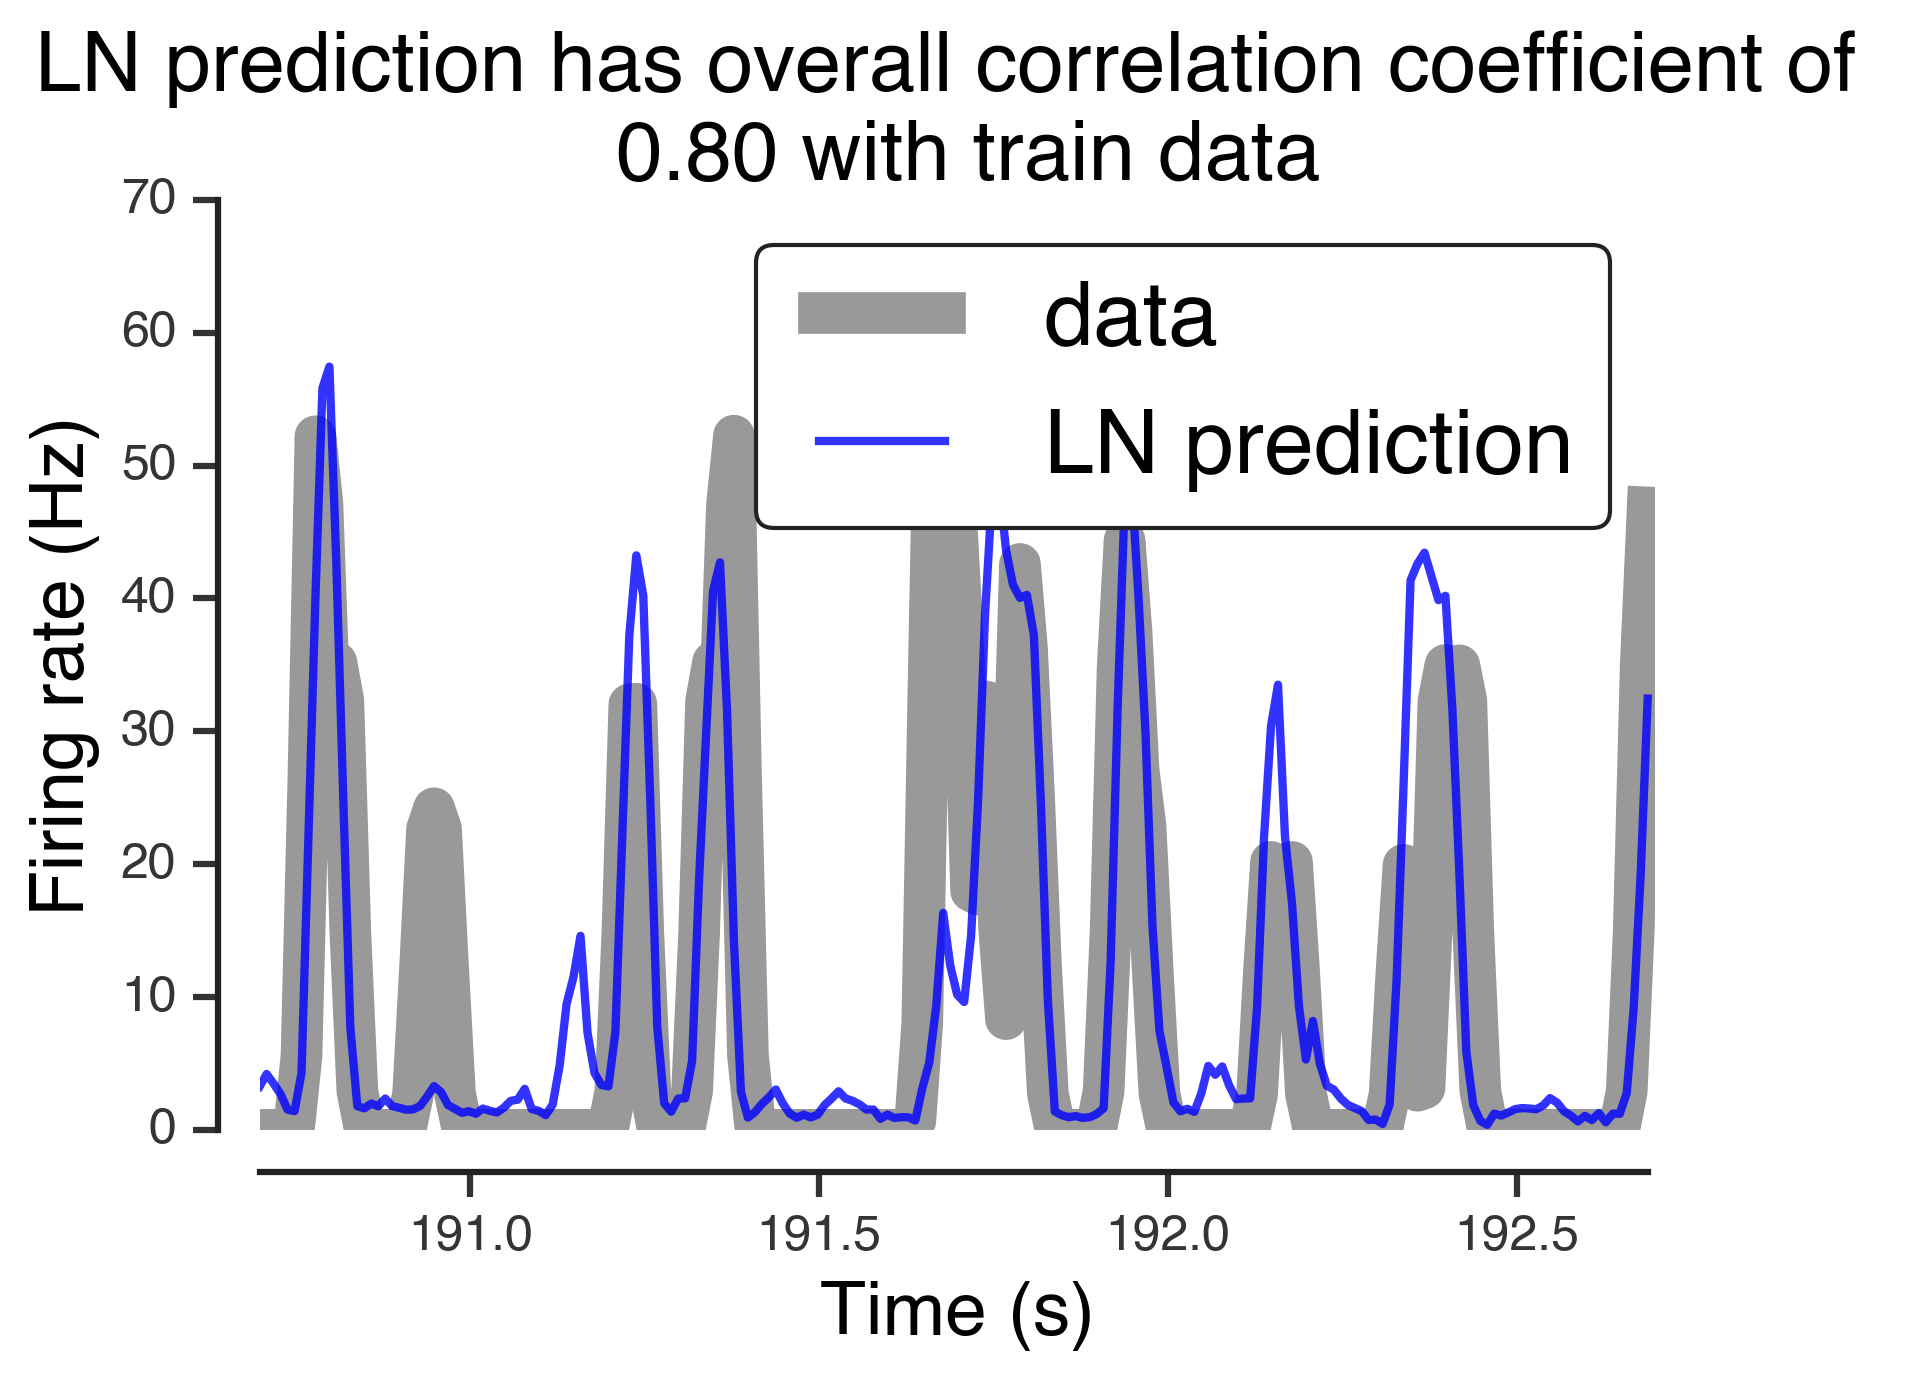

In [74]:
random_idx = np.random.choice(len(predicted_psth))
window = 200 # 100 frames is 1 second

# data
plt.plot(time[filter_length+random_idx:filter_length+random_idx+window], 
         whitenoise_psth[most_spiking_cell, filter_length+random_idx:filter_length+random_idx+window],
        'k', linewidth=10, alpha=0.4, label='data')

# LN prediction
plt.plot(time[filter_length+random_idx:filter_length+random_idx+window], 
         predicted_psth[random_idx:random_idx+window],
        'b', linewidth=2, alpha=0.8, label='LN prediction')

# compute correlation between data and prediction
LN_cc = pearsonr(whitenoise_psth[most_spiking_cell, filter_length:], predicted_psth)[0]
plt.title('LN prediction has overall correlation coefficient of \n %0.2f with train data' %LN_cc, fontsize=20)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
plt.legend()
plt.xlim([time[filter_length+random_idx], time[filter_length+random_idx+window]])
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## How well does the LN model explain the test set?

In [75]:
# Filter test stimulus
test_zscored_stimulus = zscore(test_whitenoise_stimulus)
test_filtered_stim = np.zeros((test_zscored_stimulus.shape[0]-filter_length,))
for t in range(test_zscored_stimulus.shape[0]-filter_length):
    test_filtered_stim[t] = np.inner(test_zscored_stimulus[t:t+filter_length].flat, average_feature.flat)
    if t % 5000 == 0:
        print('Filtered %d/%d' %(t,test_zscored_stimulus.shape[0]-filter_length))
        
# Predict firing rate
test_predicted_psth = nonlinearity.predict(test_filtered_stim)
LN_test_cc = pearsonr(test_whitenoise_psth[most_spiking_cell, filter_length:], test_predicted_psth)[0]
print('LN prediction has a correlation coefficient of %0.2f with the test data.' %LN_test_cc)

Filtered 0/5960
Filtered 5000/5960
LN prediction has a correlation coefficient of 0.16 with the test data.


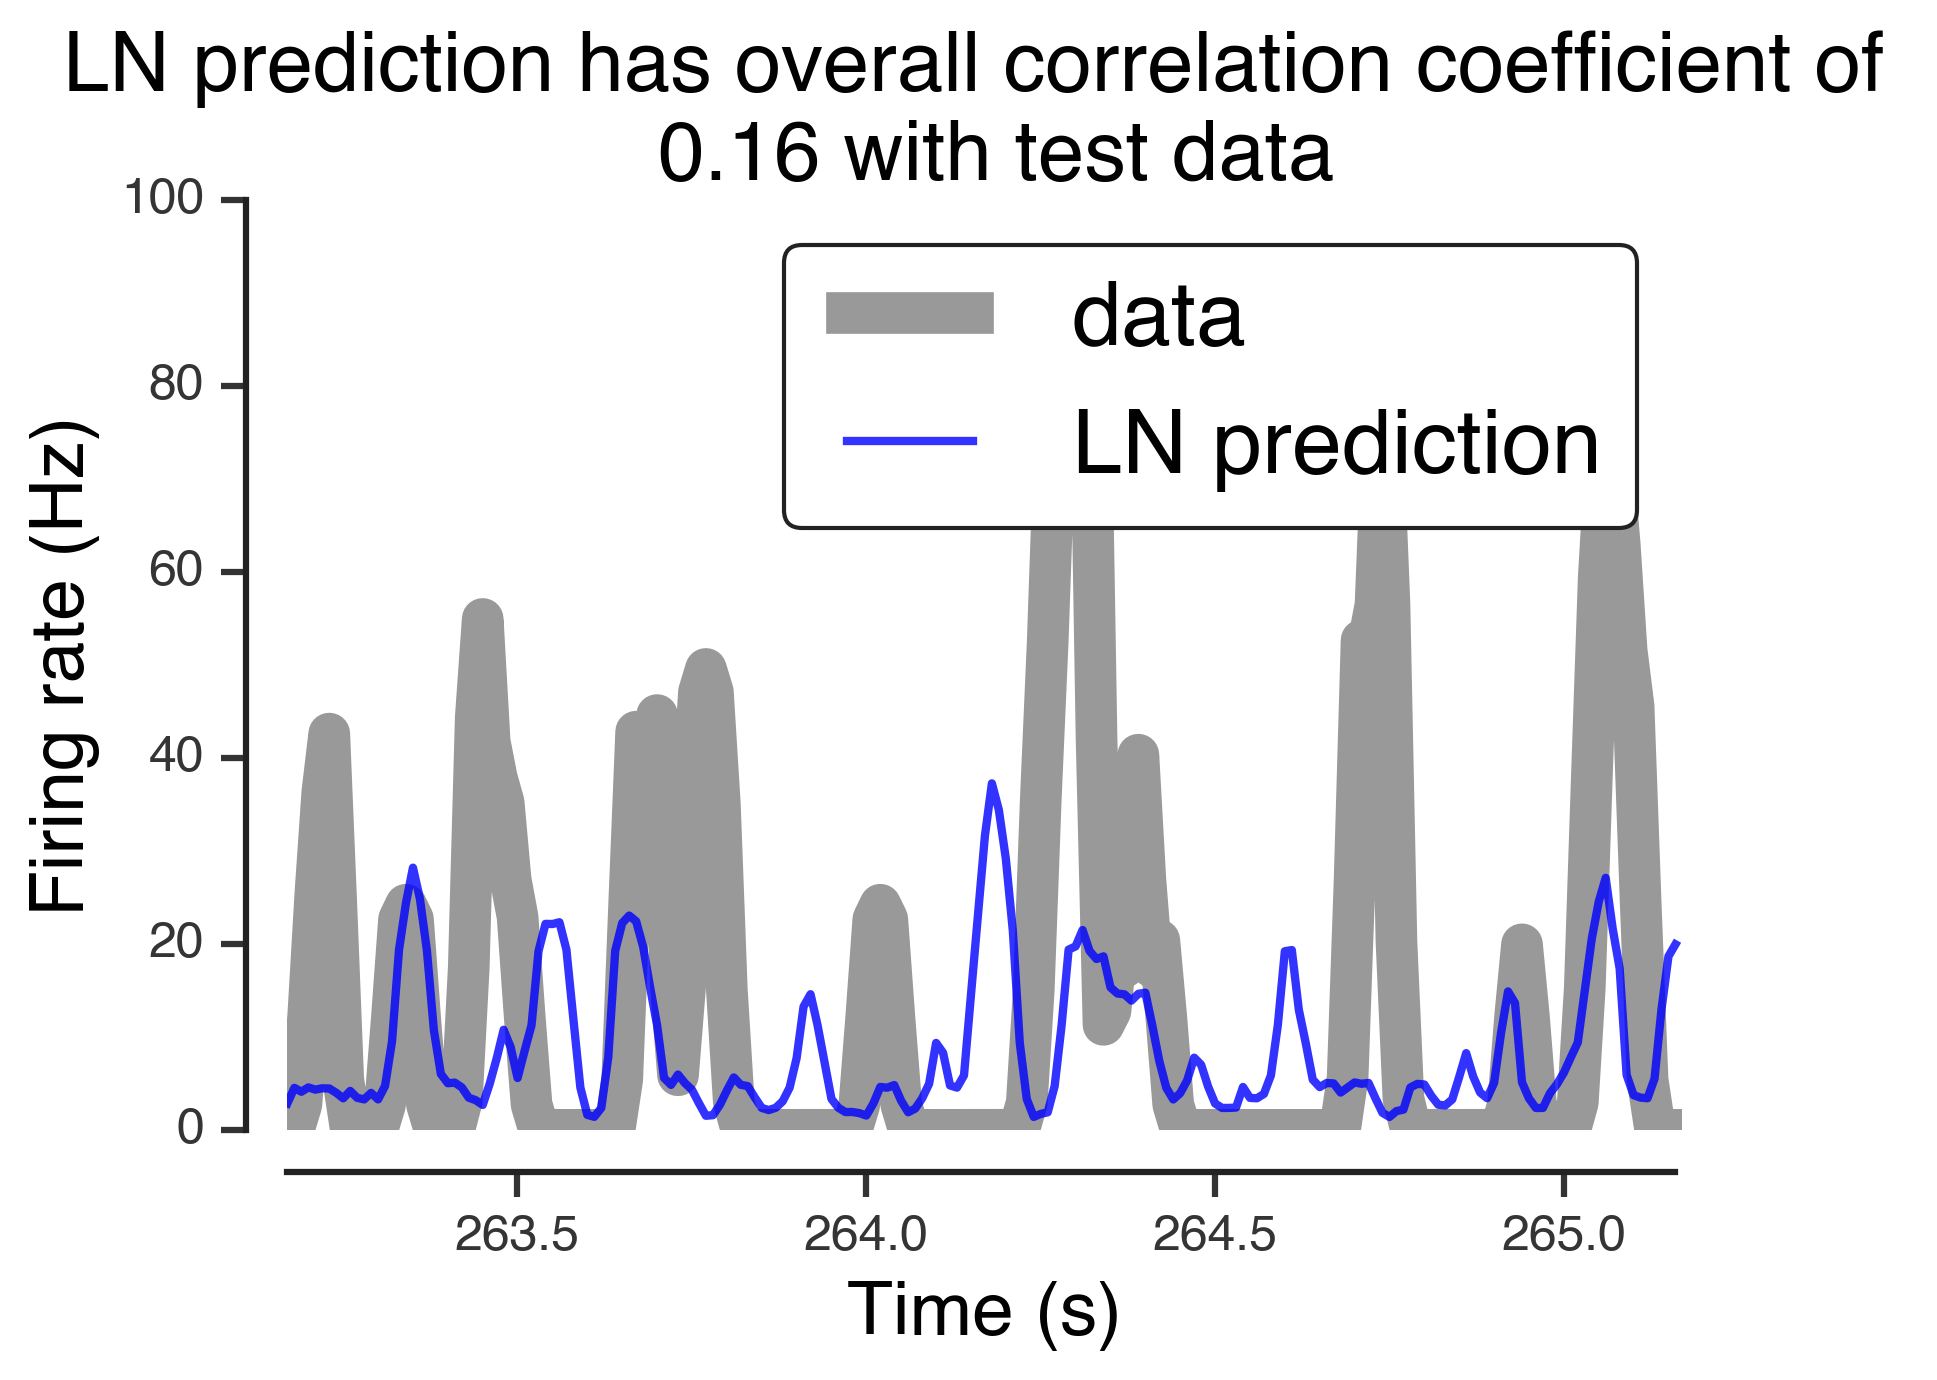

In [76]:
random_idx = np.random.choice(len(test_predicted_psth))
window = 200 # 100 frames is 1 second

# data
plt.plot(test_time[filter_length+random_idx:filter_length+random_idx+window], 
         test_whitenoise_psth[most_spiking_cell, filter_length+random_idx:filter_length+random_idx+window],
        'k', linewidth=10, alpha=0.4, label='data')

# LN prediction
plt.plot(test_time[filter_length+random_idx:filter_length+random_idx+window], 
         test_predicted_psth[random_idx:random_idx+window],
        'b', linewidth=2, alpha=0.8, label='LN prediction')

plt.title('LN prediction has overall correlation coefficient of \n %0.2f with test data' %LN_test_cc, fontsize=20)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
plt.legend()
plt.xlim([test_time[filter_length+random_idx], test_time[filter_length+random_idx+window]])
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# We just fit a linear-nonlinear model to a retinal ganglion cell.  

Improving the performance of an LN model on test data requires lots of regularization. We won't do this today.

## Next we will add a Poisson random variable to this model and compare it to retinal noise.  

Example raster of LN-Poisson model

In [77]:
predicted_spike_raster = poisson.rvs(predicted_psth/sample_rate)

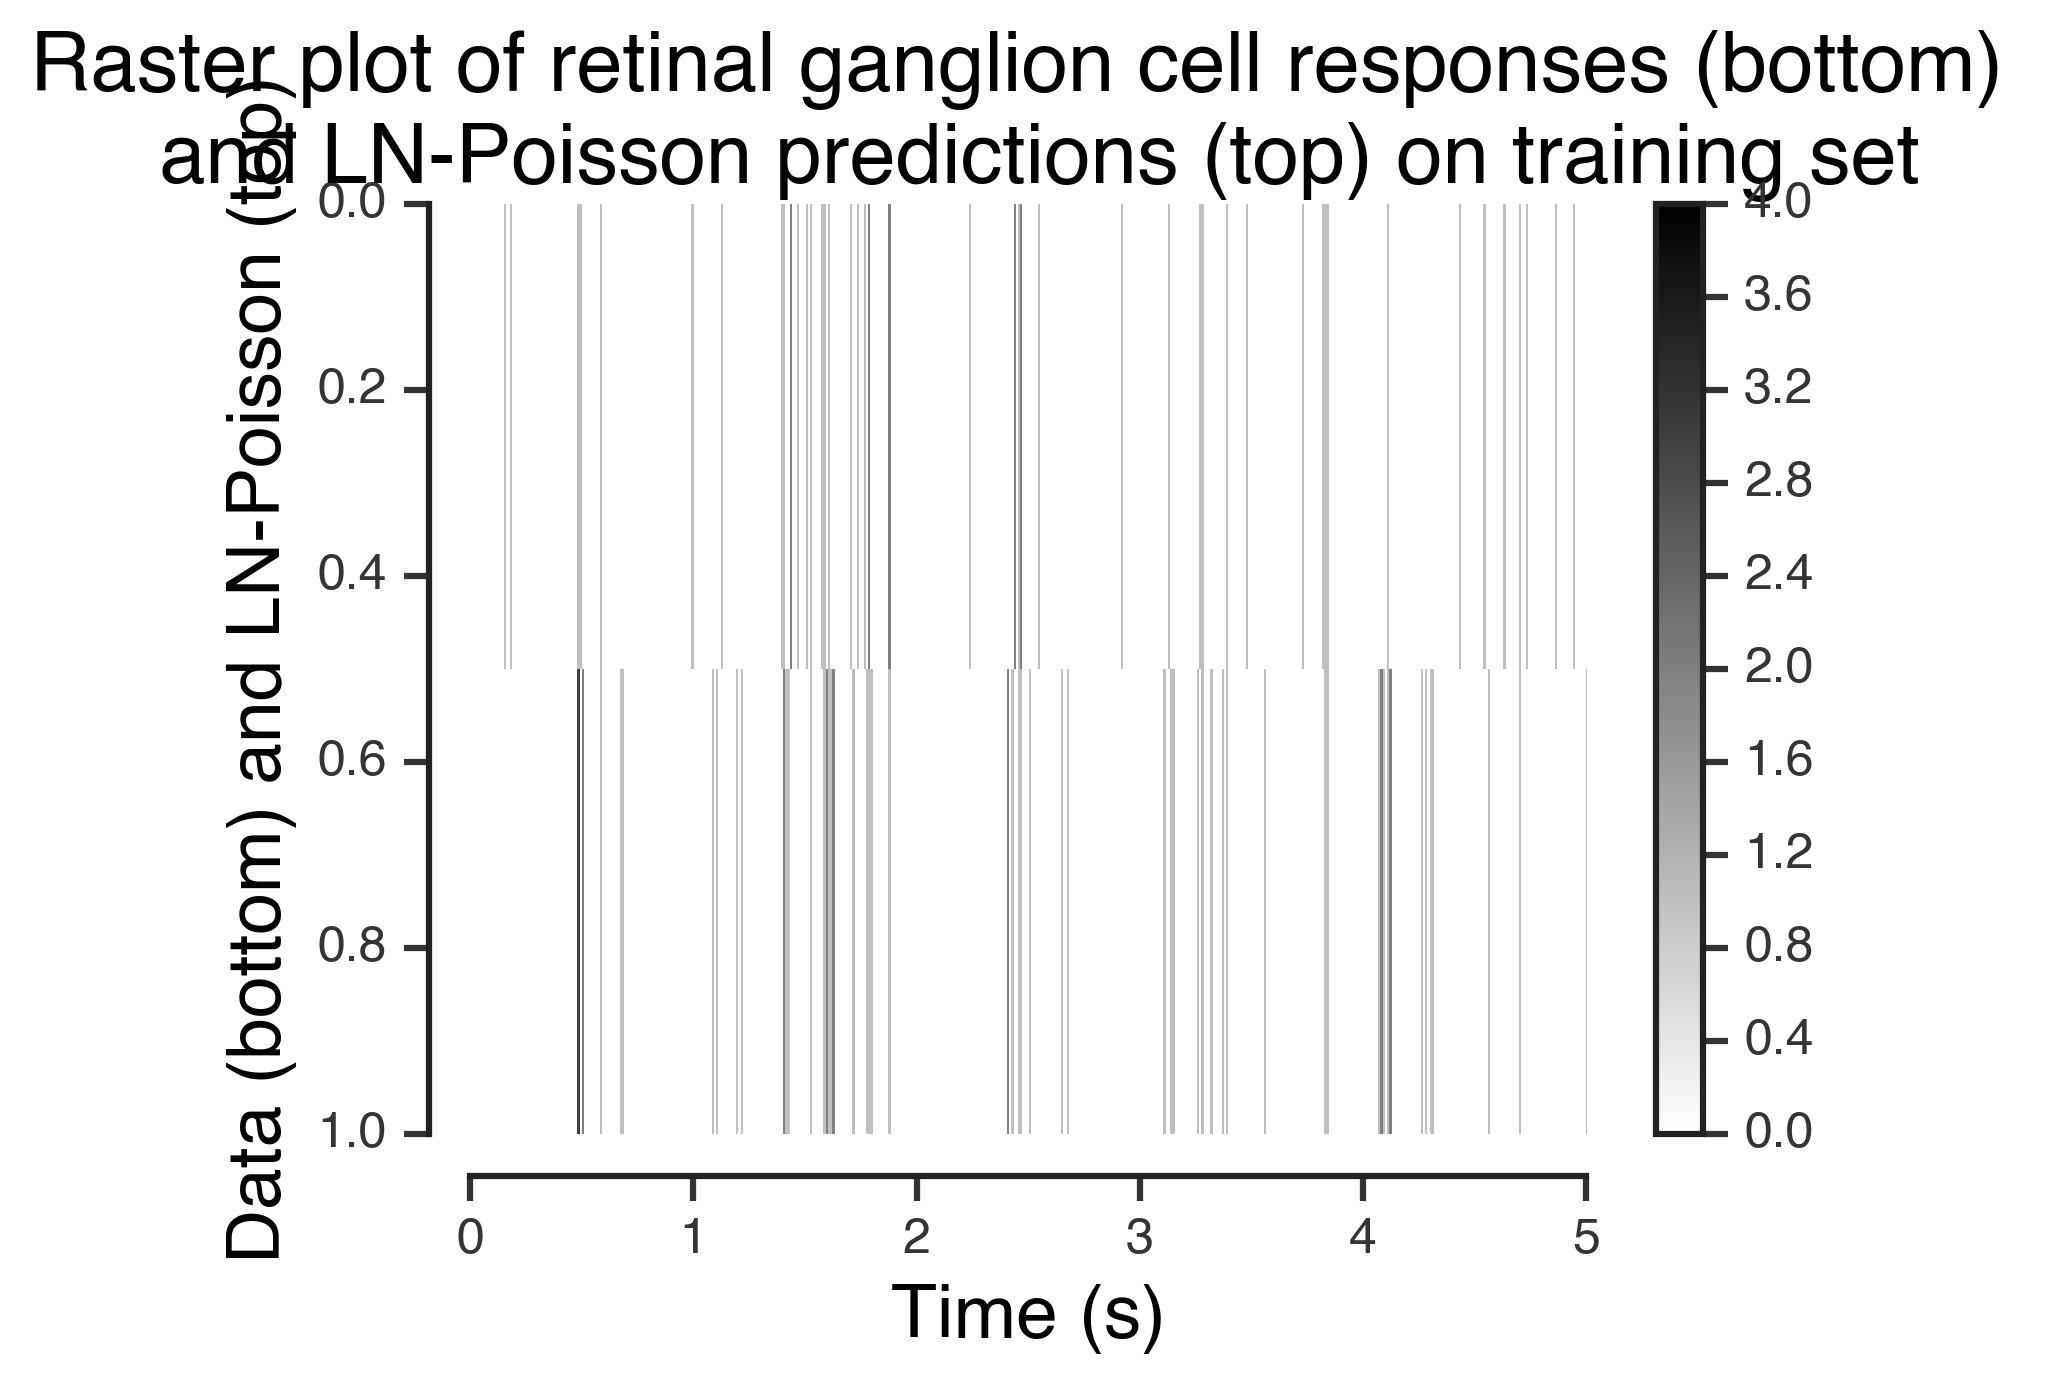

In [78]:
plt.imshow(np.stack([predicted_spike_raster, 
                     whitenoise_response[most_spiking_cell, 0, filter_length:]]), aspect='auto', cmap='gray_r', 
           extent=(time[0], time[-1], 1, 0))

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Data (bottom) and LN-Poisson (top)', fontsize=18)
plt.title('Raster plot of retinal ganglion cell responses (bottom) \n and LN-Poisson predictions (top) on training set', fontsize=20)
plt.colorbar()
plt.xlim([0,5]) # plot first 5 seconds
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# It's difficult to tell if a Poisson assumption makes sense from just two repeats.

# Let's move to a dataset with many repeats - and one that is more natural.

## Load retinal dataset with 112 repeats of 30s natural scenes

In [79]:
with h5py.File(expanduser('~/data/deep-retina-tutorial/data/naturalscene.h5'), 'r') as h:
    stimulus = np.array(np.array(h['test/stimulus']))
    psth = np.array(h['test/response/firing_rate_10ms'])
    repeats = np.stack([np.array(h['test/repeats/%s' %key]) for key in sorted(h['test/repeats'].keys())])
    time = np.array(h['test/time'])

## Visual stimulus

In [80]:
stimulus.shape

(3003, 50, 50)

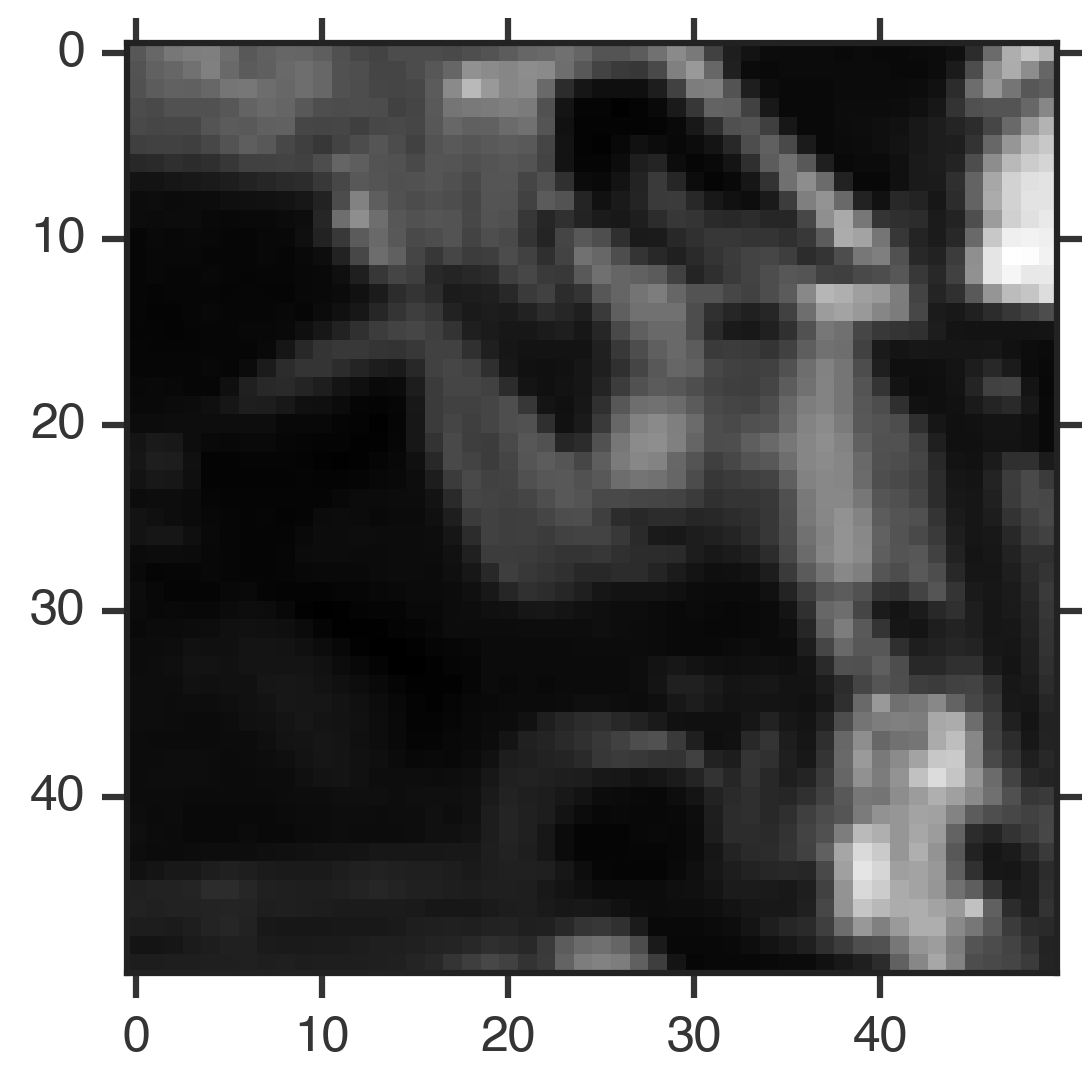

In [81]:
plt.imshow(stimulus[200])

## What does the average output of the retina look like?

In [82]:
psth.shape

(28, 3003)

#### Visualize average responses of all 28 cells for first 5 seconds of each repeat

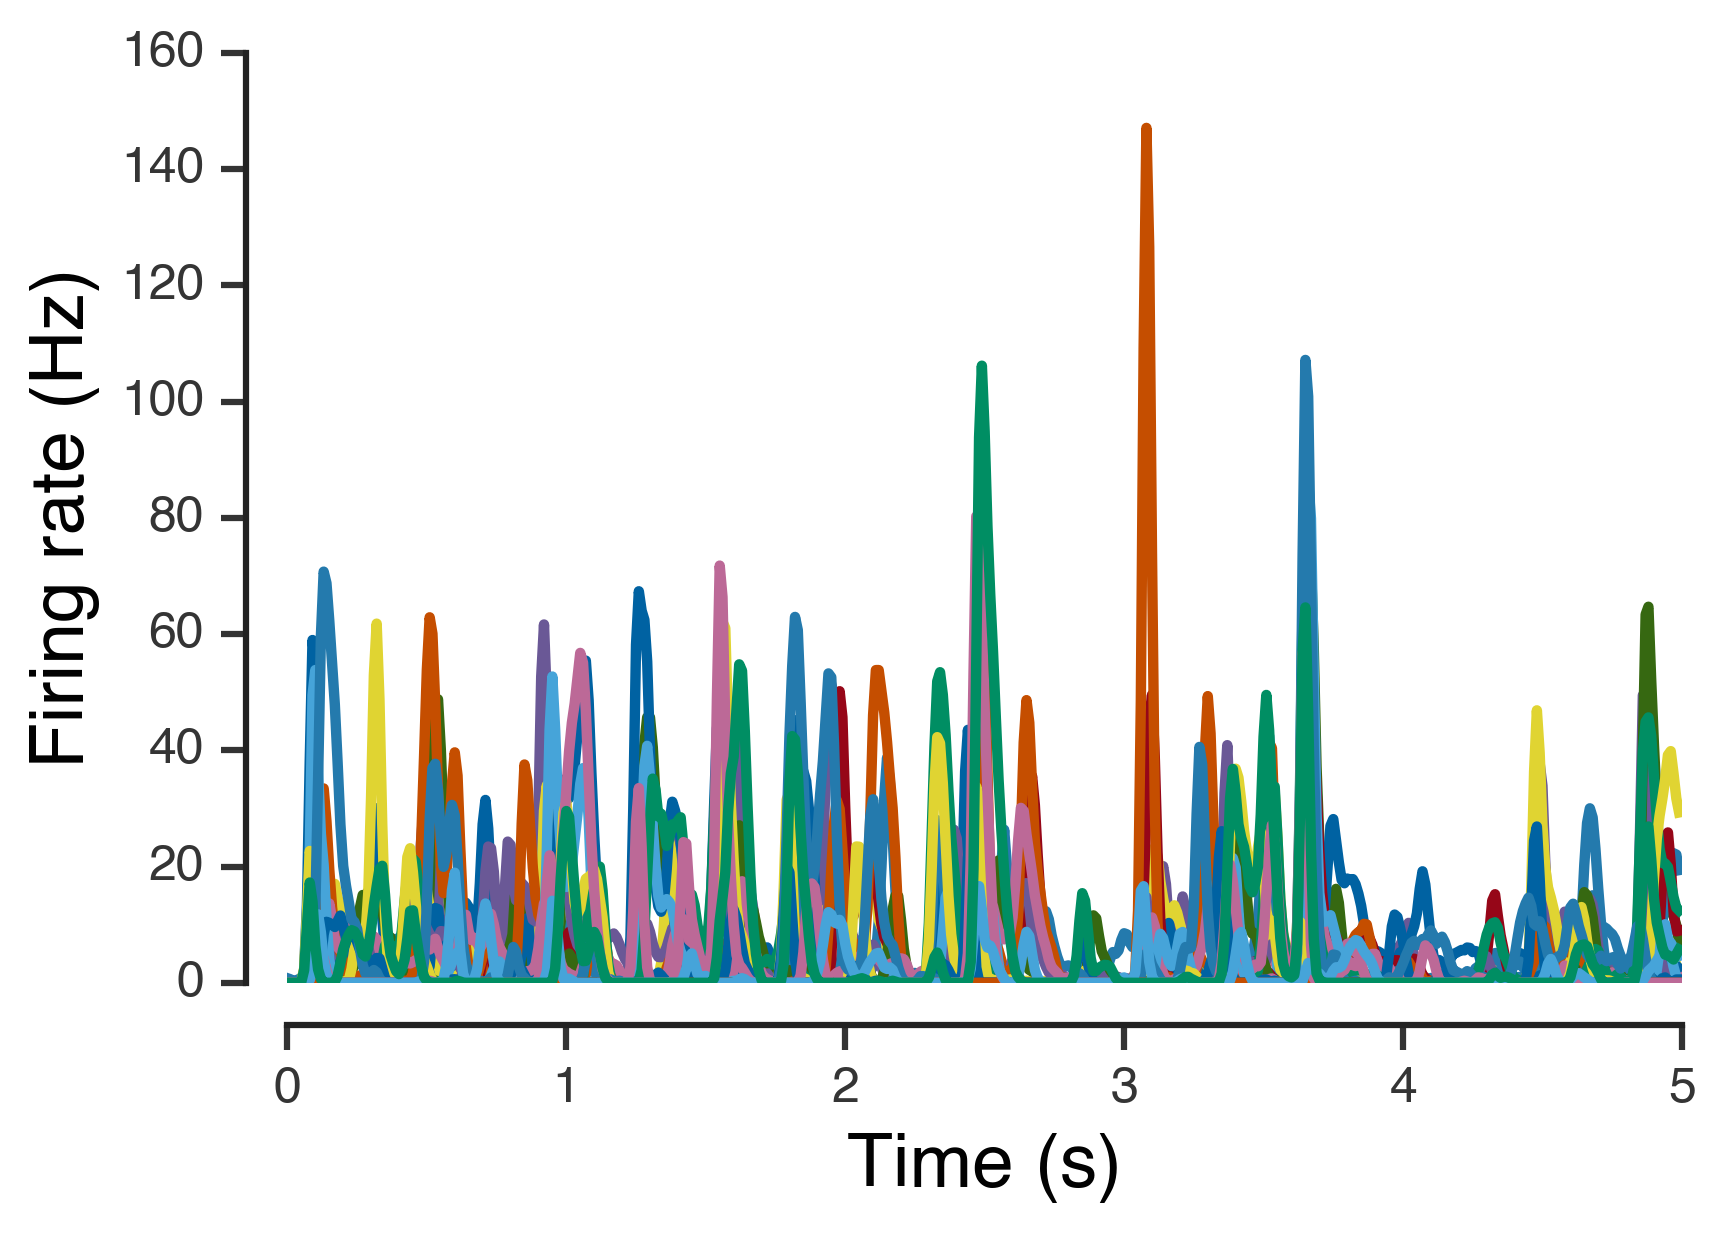

In [83]:
p = plt.plot(time[:500], psth[:,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Qualitatively look at how change of natural scene every 1s relates to retinal firing for example cell

(0, 5)

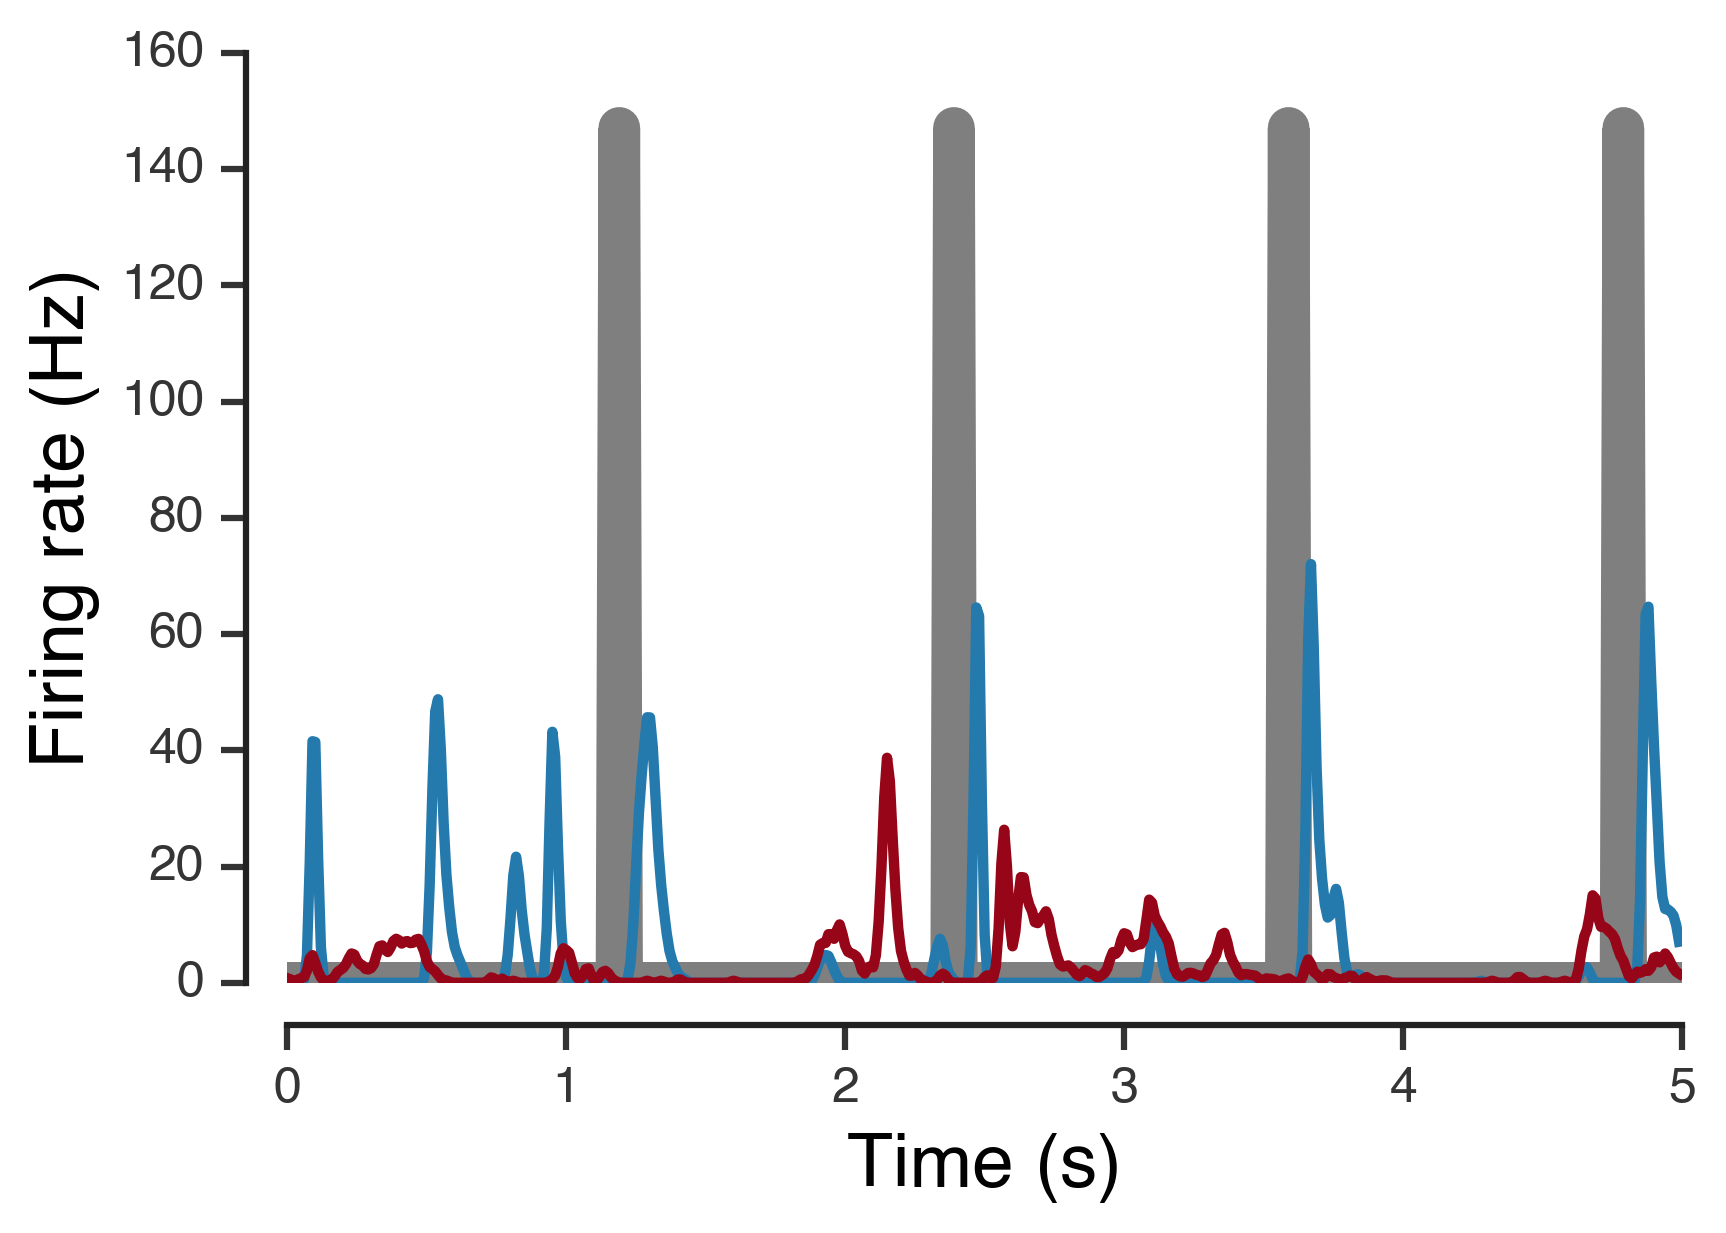

In [84]:
# Plot mean difference between frames
mean_stimulus_difference = abs(np.mean(np.diff(stimulus.astype('float32'), axis=0), axis=(1,2)))
plt.plot(time[:-1], np.max(psth)*np.where(mean_stimulus_difference > 2*np.std(mean_stimulus_difference), 1, 0), 
         'k', linewidth=10, alpha=0.5)

p = plt.plot(time[:500], psth[3,:500].T)
p = plt.plot(time[:500], psth[0,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0,5])

## Characterizing retinal noise

In [85]:
repeats.shape

(28, 112, 3003)

#### Raster of just one cell

In [86]:
cell_id = 12

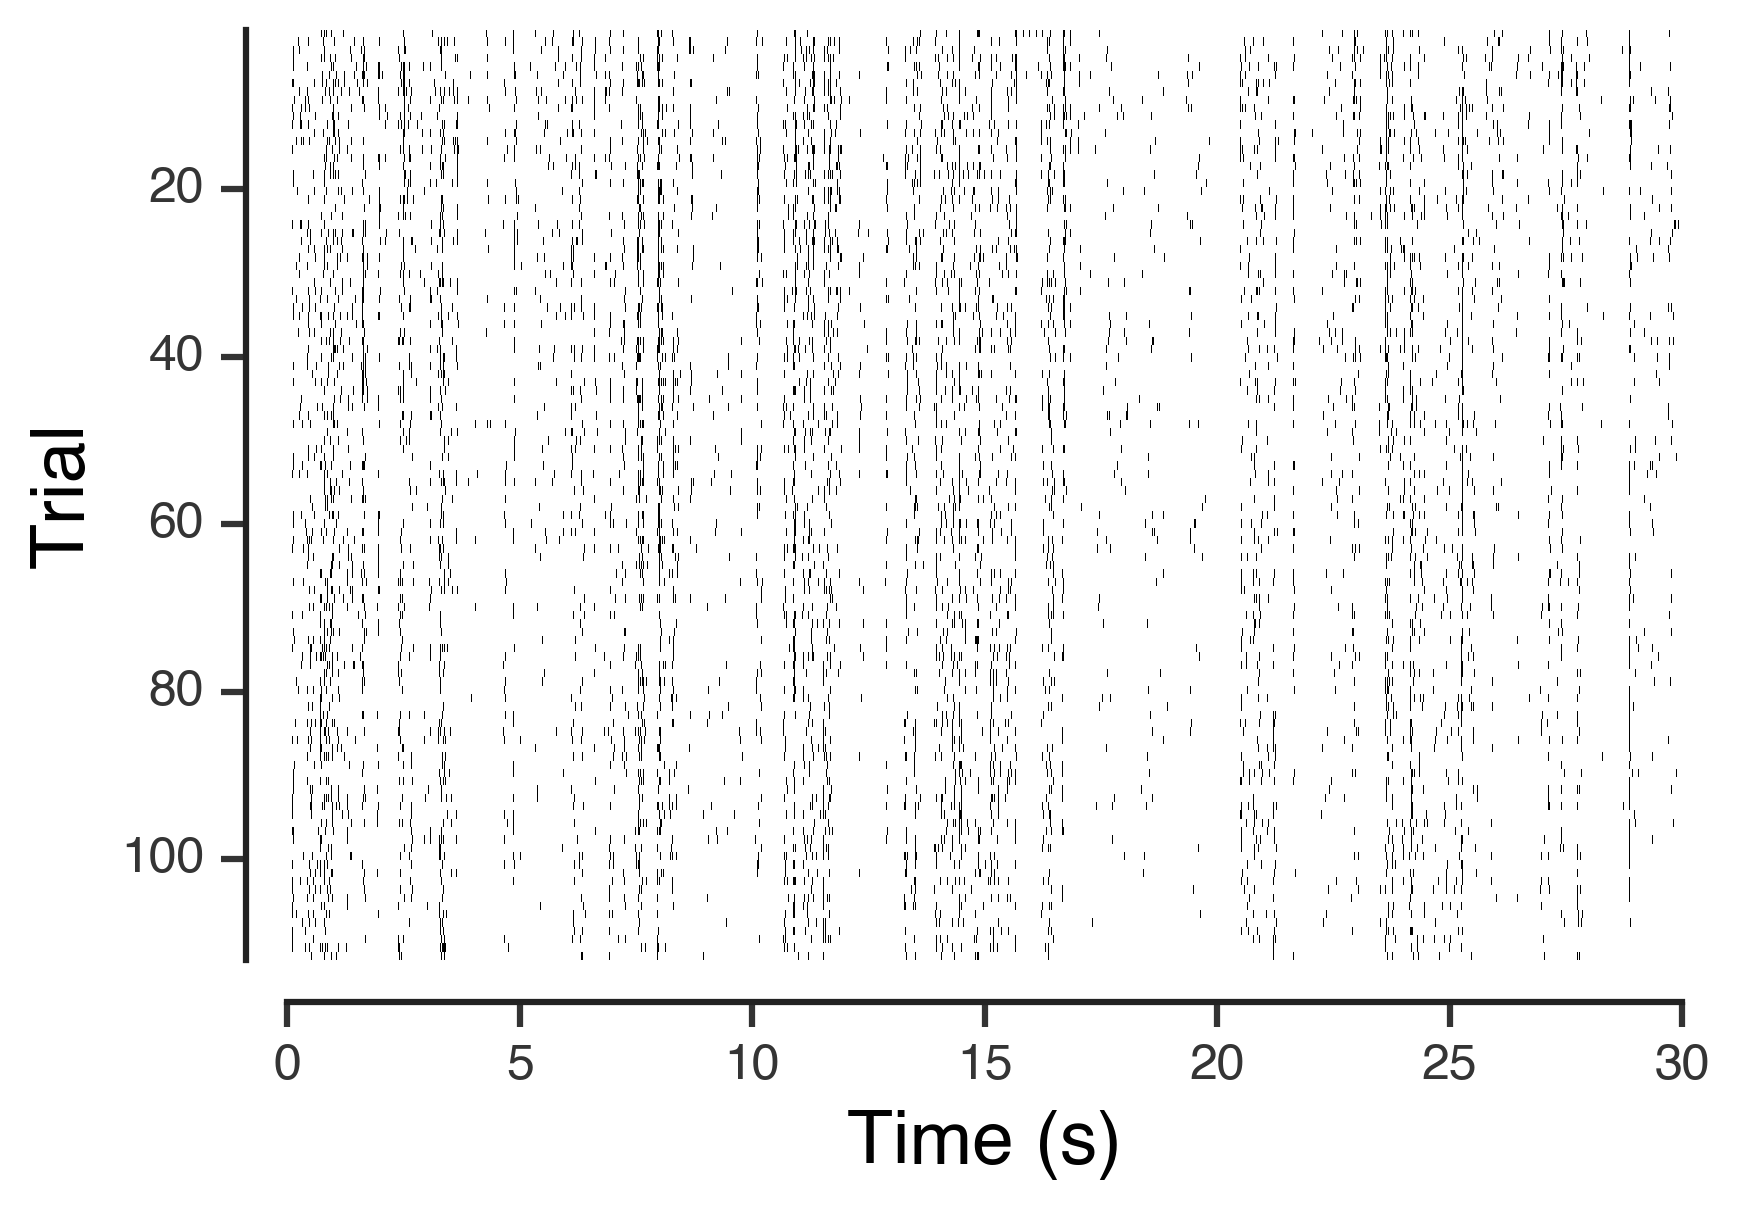

In [87]:
plt.imshow(repeats[cell_id], aspect='auto', clim=[0,1], cmap='gray_r', extent=(time[0], time[-1], repeats.shape[1], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Trial', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

In [91]:
np.var(repeats[0, 0, :])

0.041639568113094591

In [92]:
np.var(repeats[0, :, 0])

0.0088488520408163251

In [93]:
np.var(np.mean(repeats[0], axis=0))

0.0016725771208851905

In [100]:
snrs_using_psth = []
snrs_using_raw = []
# for each cell
for these_repeats in repeats:
    if np.max(these_repeats) > 0:
        psth_variability_across_time = np.var(np.mean(these_repeats, axis=0))
        variability_across_time = []
        variability_across_trial = []

        for r in range(these_repeats.shape[0]):
            variability_across_time.append(np.var(these_repeats[r,:]))
        for t in range(these_repeats.shape[-1]):
            variability_across_trial.append(np.var(these_repeats[:,t]))

        snrs_using_psth.append(psth_variability_across_time/np.nanmean(variability_across_trial))
        snrs_using_raw.append(np.nanmean(variability_across_time)/np.nanmean(variability_across_trial))
    else:
        snrs_using_psth.append(np.nan)
        snrs_using_raw.append(np.nan)

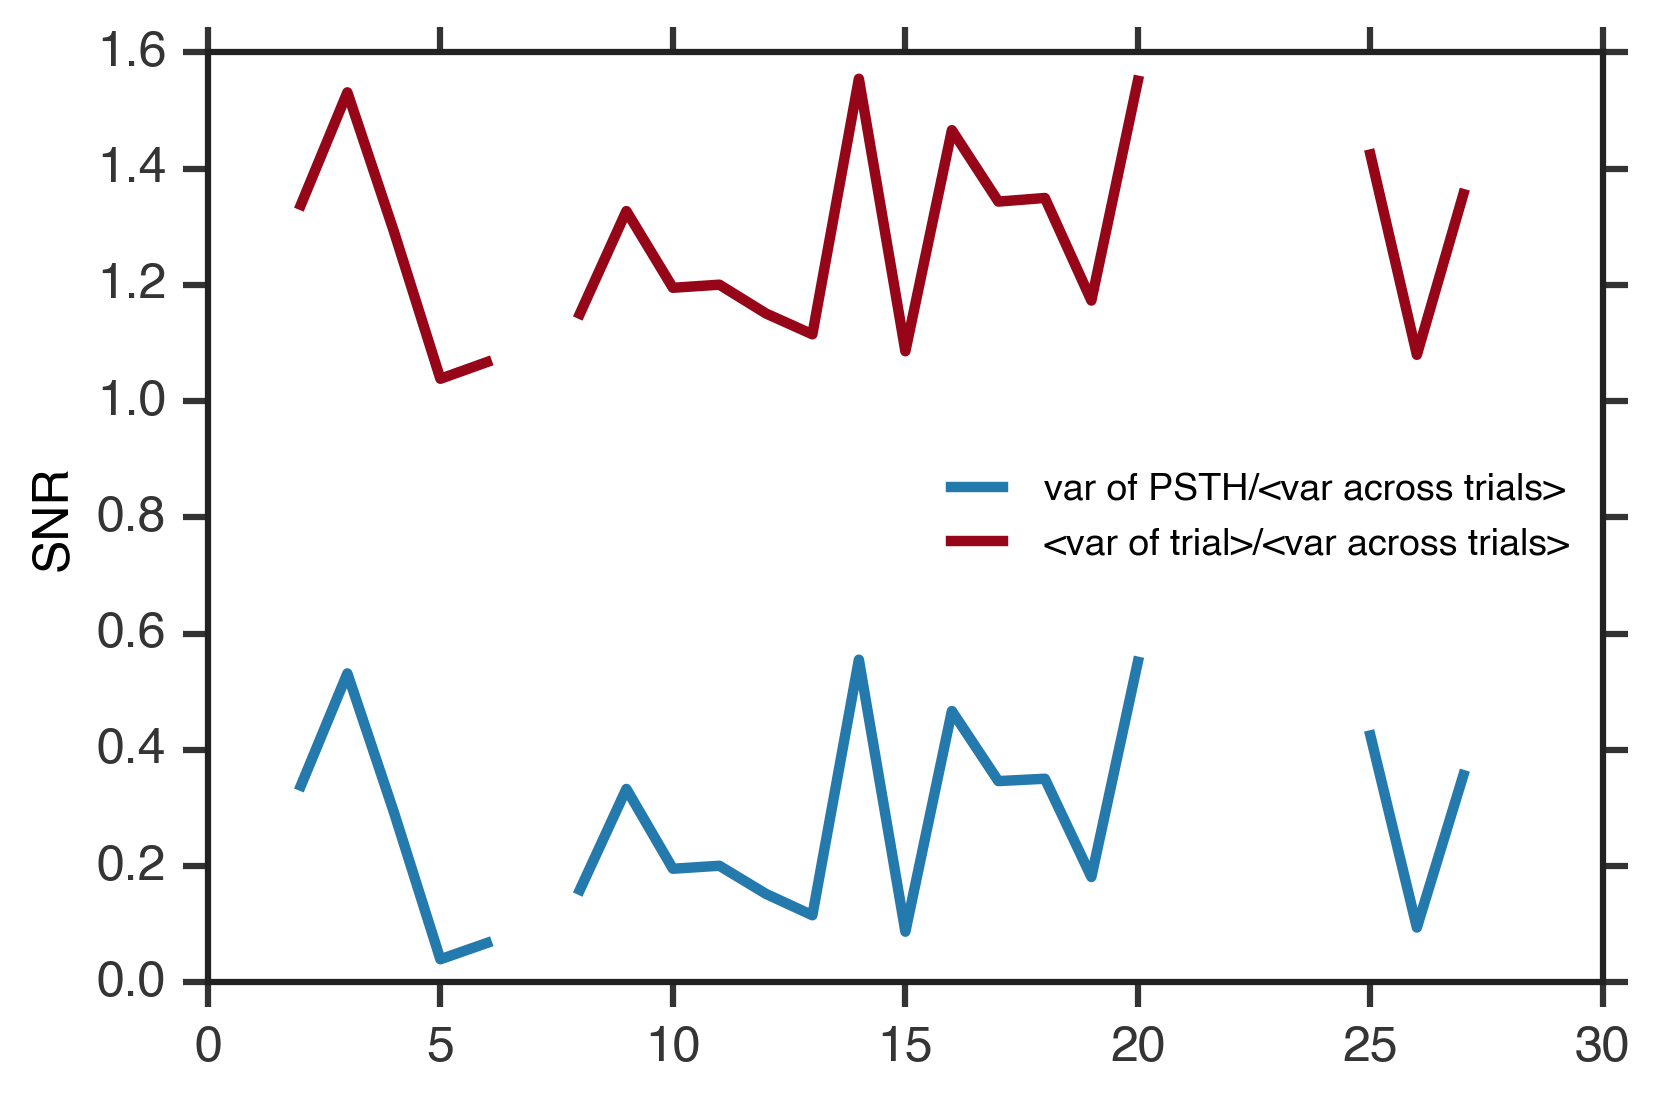

In [101]:
plt.plot(snrs_using_psth, label='var of PSTH/<var across trials>')
plt.plot(snrs_using_raw, label='<var of trial>/<var across trials>')
plt.legend(frameon=False, fontsize=9, loc='center right')
plt.ylabel('SNR')

In [102]:
np.nanmean(snrs_using_psth)

0.26912469101829534

In [103]:
np.nanmean(snrs_using_raw)

1.2666558600259068

In [104]:
from scipy.stats import sem

In [107]:
sem([s for s in snrs_using_psth if s not in [np.nan]])

0.03550918374261295

In [108]:
sem([s for s in snrs_using_raw if s not in [np.nan]])

0.035784812872868388

## Actually, can't we define the noise to be the residual of a trial after subtracting the mean?

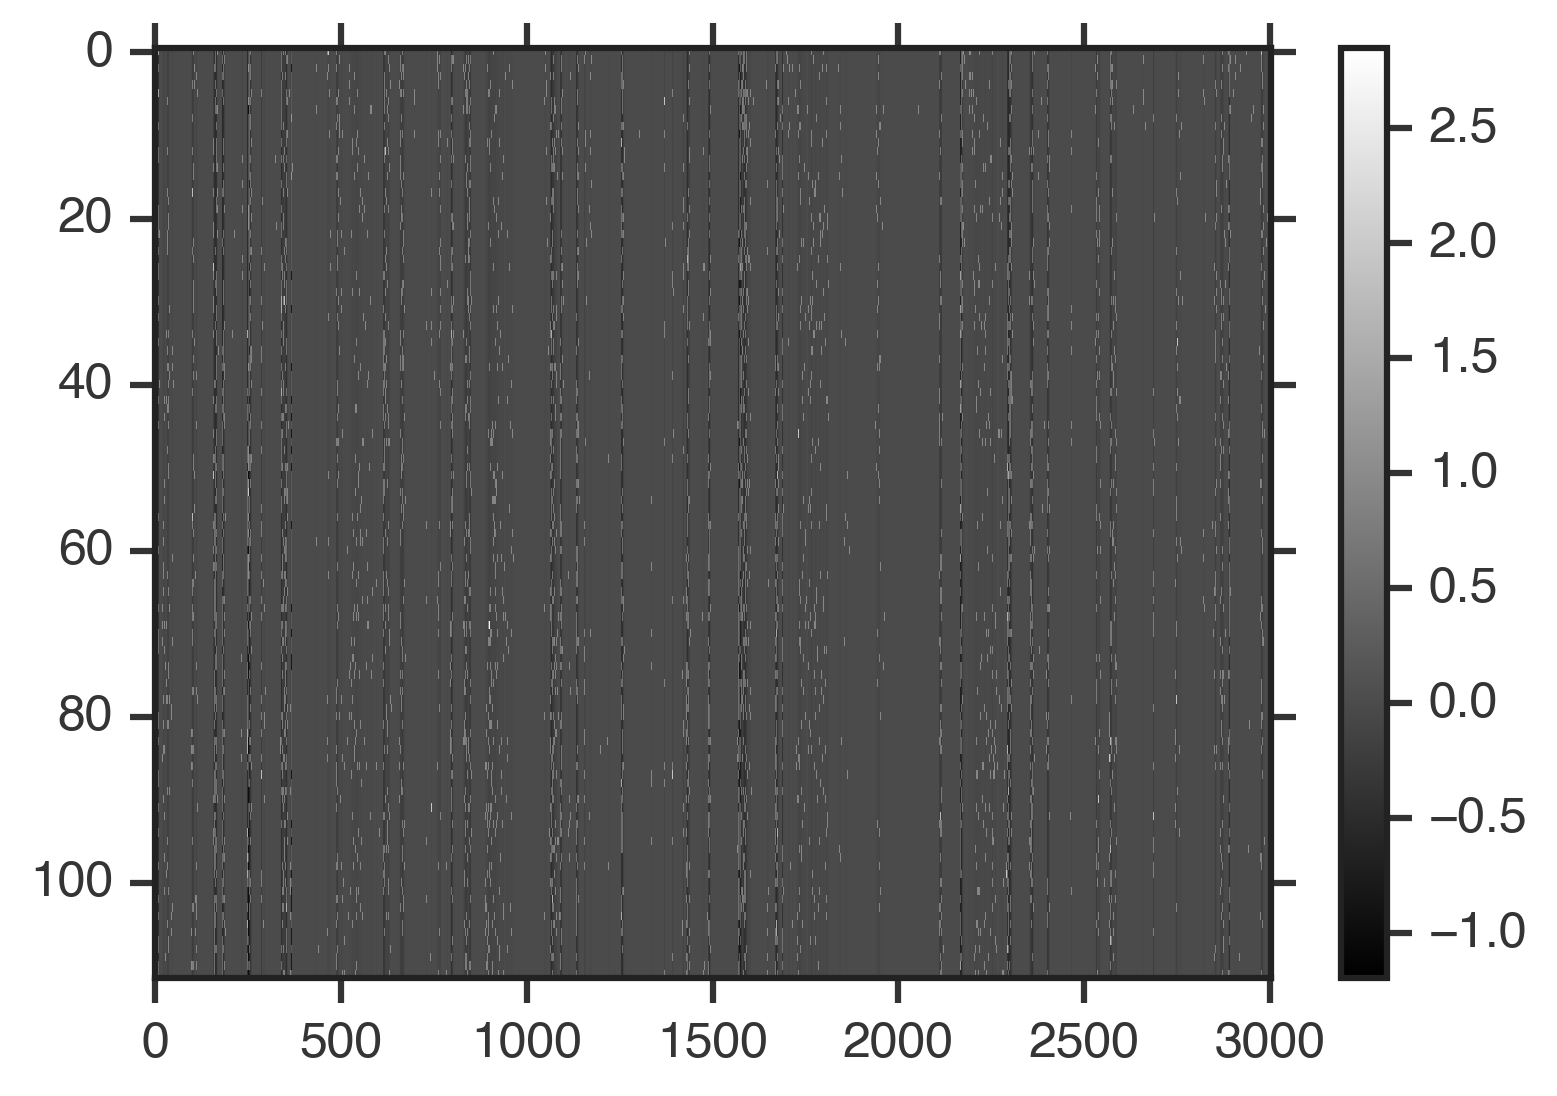

In [40]:
plt.imshow(these_repeats - np.mean(these_repeats, axis=0), aspect='auto')
plt.colorbar()

In [110]:
snrs_using_residuals = []
snrs_at_repeats = []
snrs_using_psth_and_residuals = []

for these_repeats in repeats:
    if np.max(these_repeats) > 0:
        psth_variability_across_time = np.var(np.mean(these_repeats, axis=0))
        residuals = these_repeats - np.mean(these_repeats, axis=0)
        signal_across_time = []
        variability_across_time = []
        snr_at_each_repeat = []

        for r in range(these_repeats.shape[0]):
            signal_across_time.append(np.var(these_repeats[r,:]))
            variability_across_time.append(np.var(residuals[r,:]))
            snr_at_each_repeat.append(np.var(these_repeats[r,:])/np.var(residuals[r,:]))

        snrs_using_residuals.append(np.nanmean(signal_across_time)/np.nanmean(variability_across_time))
        snrs_at_repeats.append(snr_at_each_repeat)
        snrs_using_psth_and_residuals.append(psth_variability_across_time/np.nanmean(variability_across_time))
    else:
        snrs_using_residuals.append(np.nan)
        snrs_at_repeats.append(np.nan)
        snrs_using_psth_and_residuals.append(np.nan)

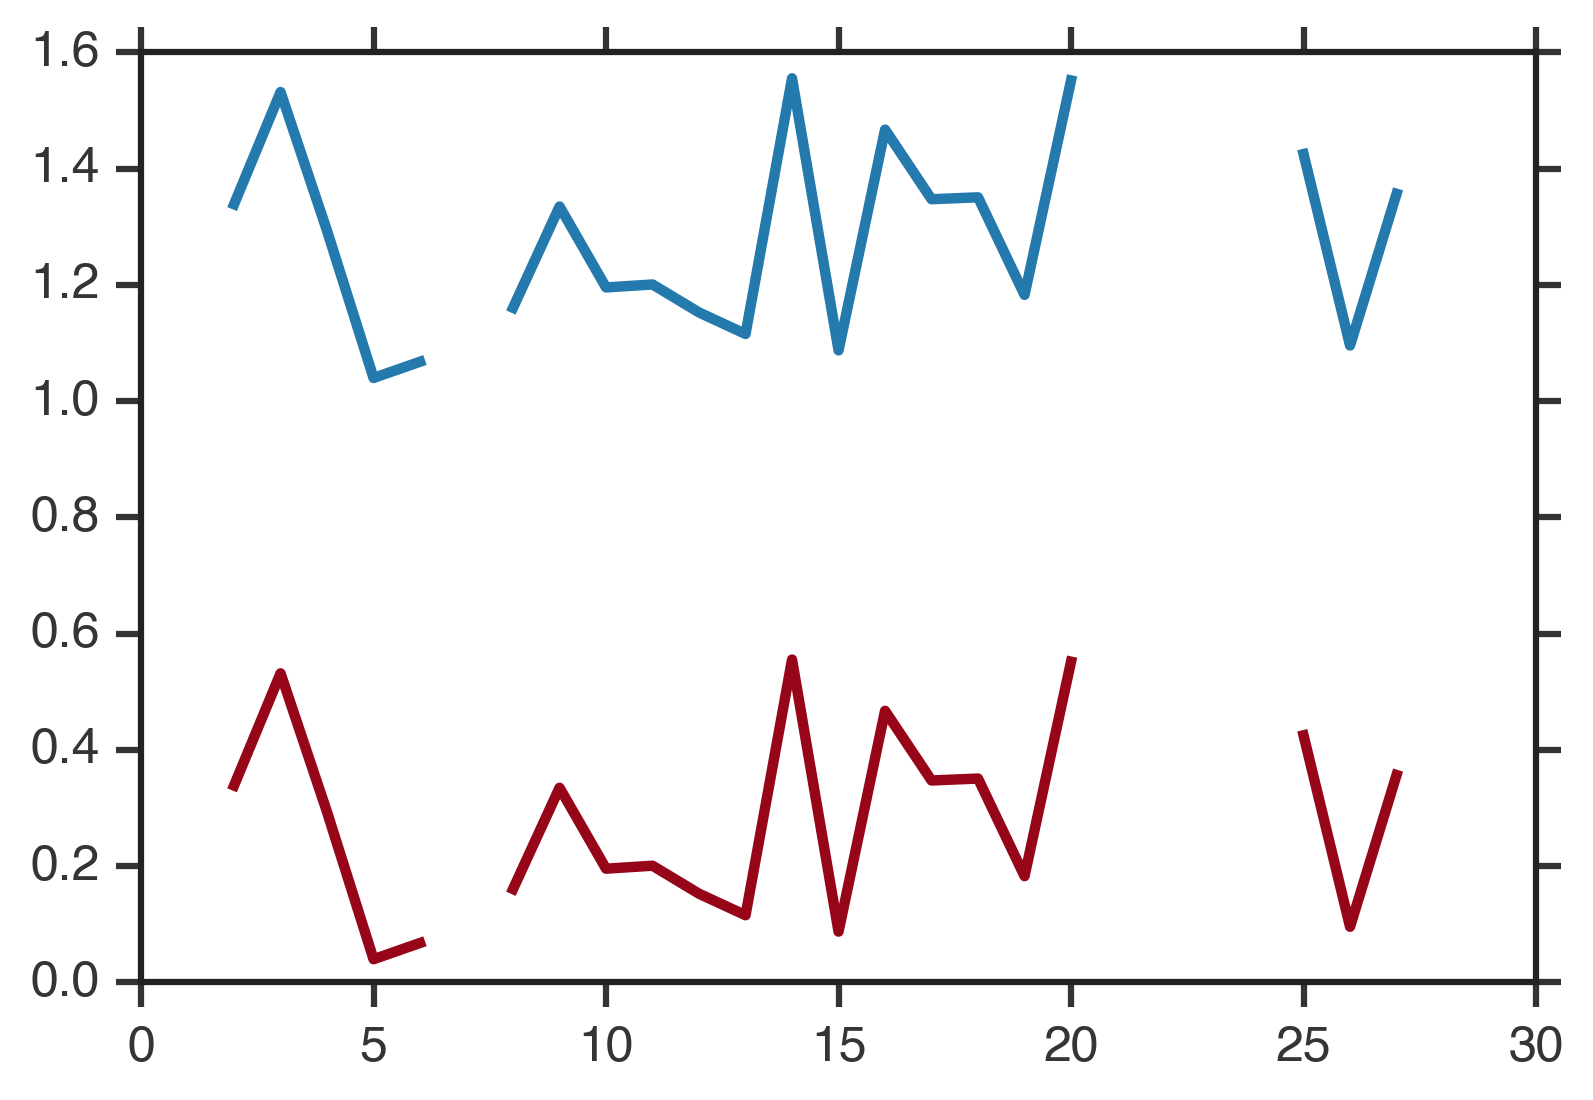

In [111]:
plt.plot(snrs_using_residuals)
plt.plot(snrs_using_psth_and_residuals)

In [112]:
np.nanmean(snrs_using_residuals)

1.2695921563886901

In [113]:
sem([s for s in snrs_using_residuals if s not in [np.nan]])

0.035501846249367204

In [114]:
np.nanmean(snrs_using_psth_and_residuals)

0.26959215638868989

In [115]:
sem([s for s in snrs_using_psth_and_residuals if s not in [np.nan]])

0.035501846249367204

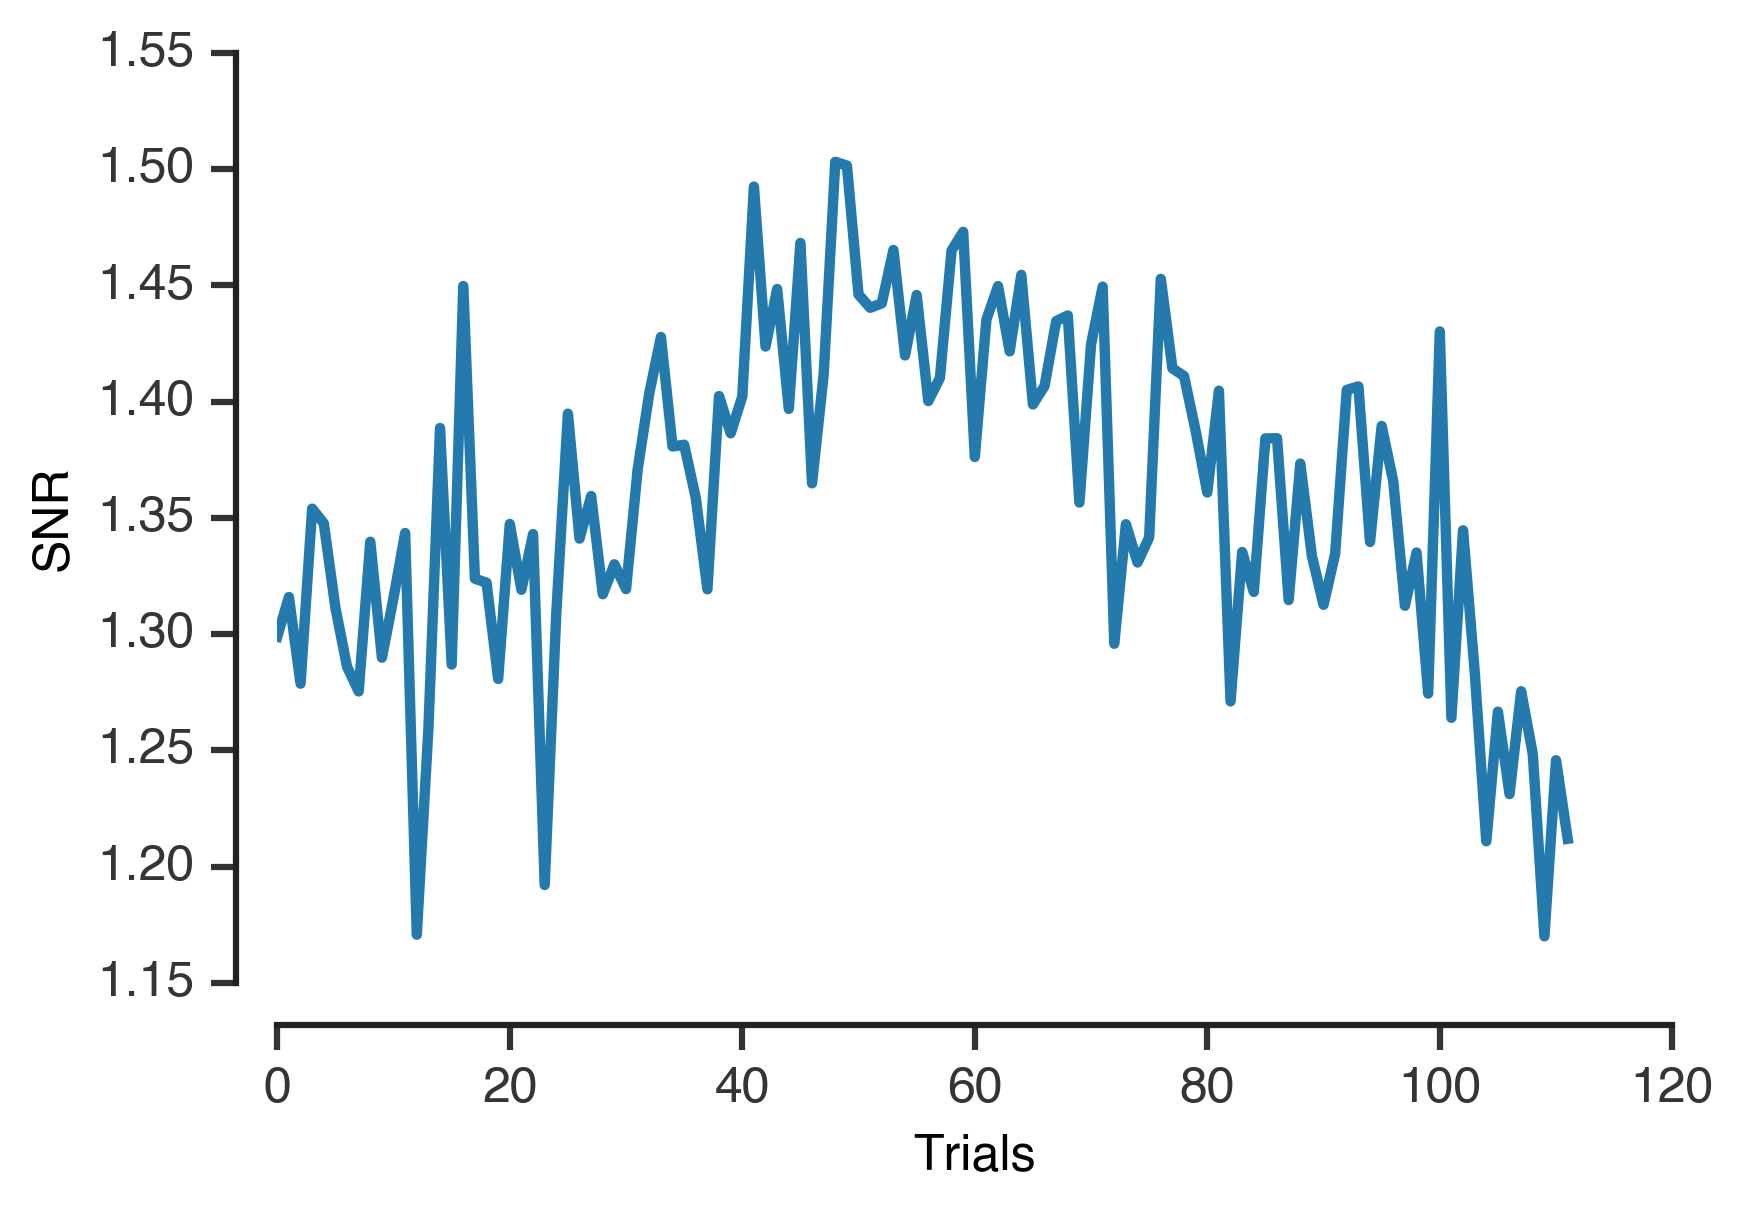

In [44]:
plt.plot(snr_at_each_repeat)
adjust_spines(plt.gca())
plt.xlabel('Trials')
plt.ylabel('SNR')

In [45]:
np.stack(snrs_at_repeats).shape

(28, 112)

## So this is calculated by taking the mean across trials to get the average signal. Then the variance across time is calculated to get the signal, and the variance across time of the residuals is the noise.

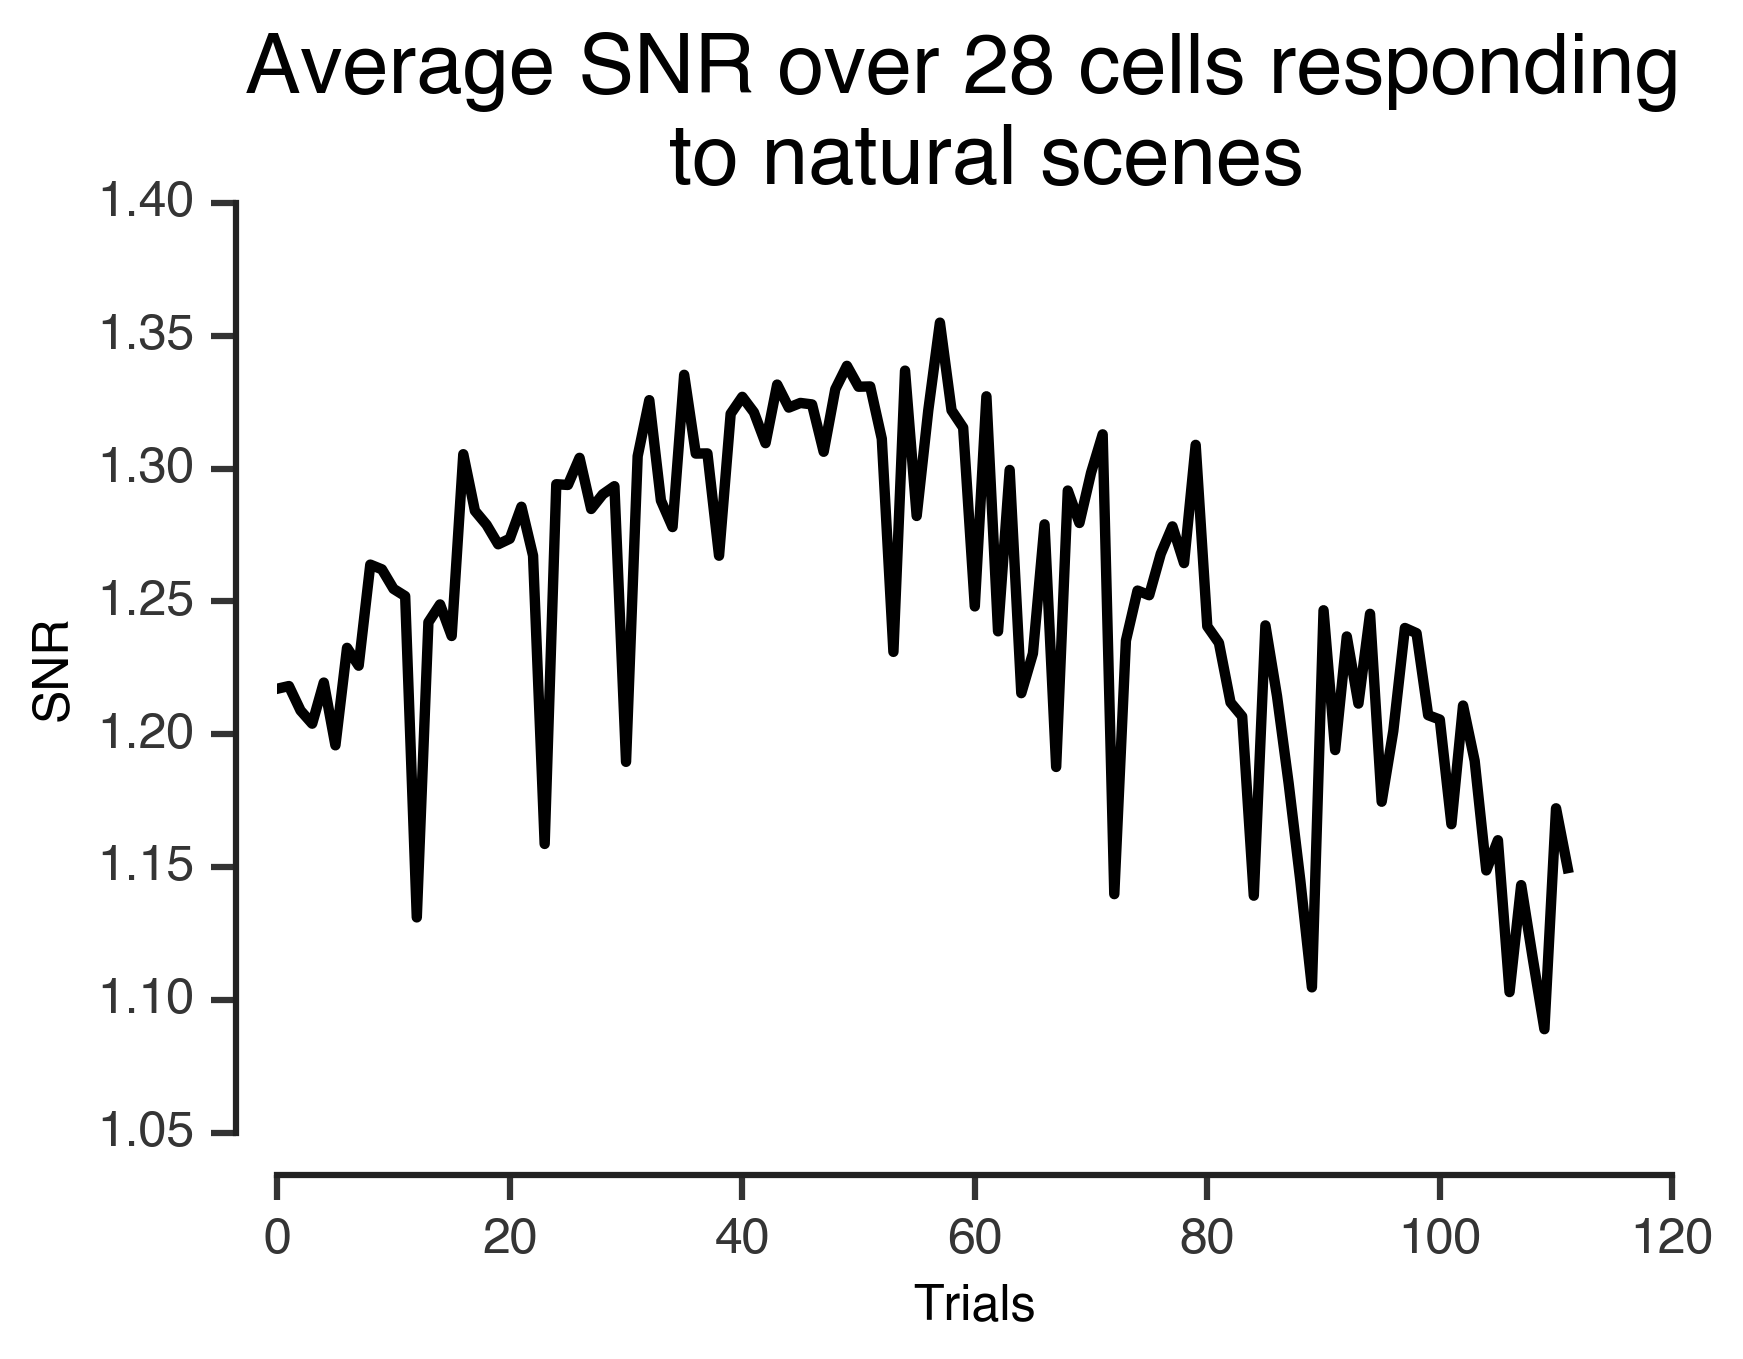

In [50]:
plt.plot(np.nanmean(np.stack(snrs_at_repeats), axis=0), 'k')
adjust_spines(plt.gca())
plt.xlabel('Trials')
plt.ylabel('SNR')
plt.title('Average SNR over 28 cells responding \n to natural scenes')

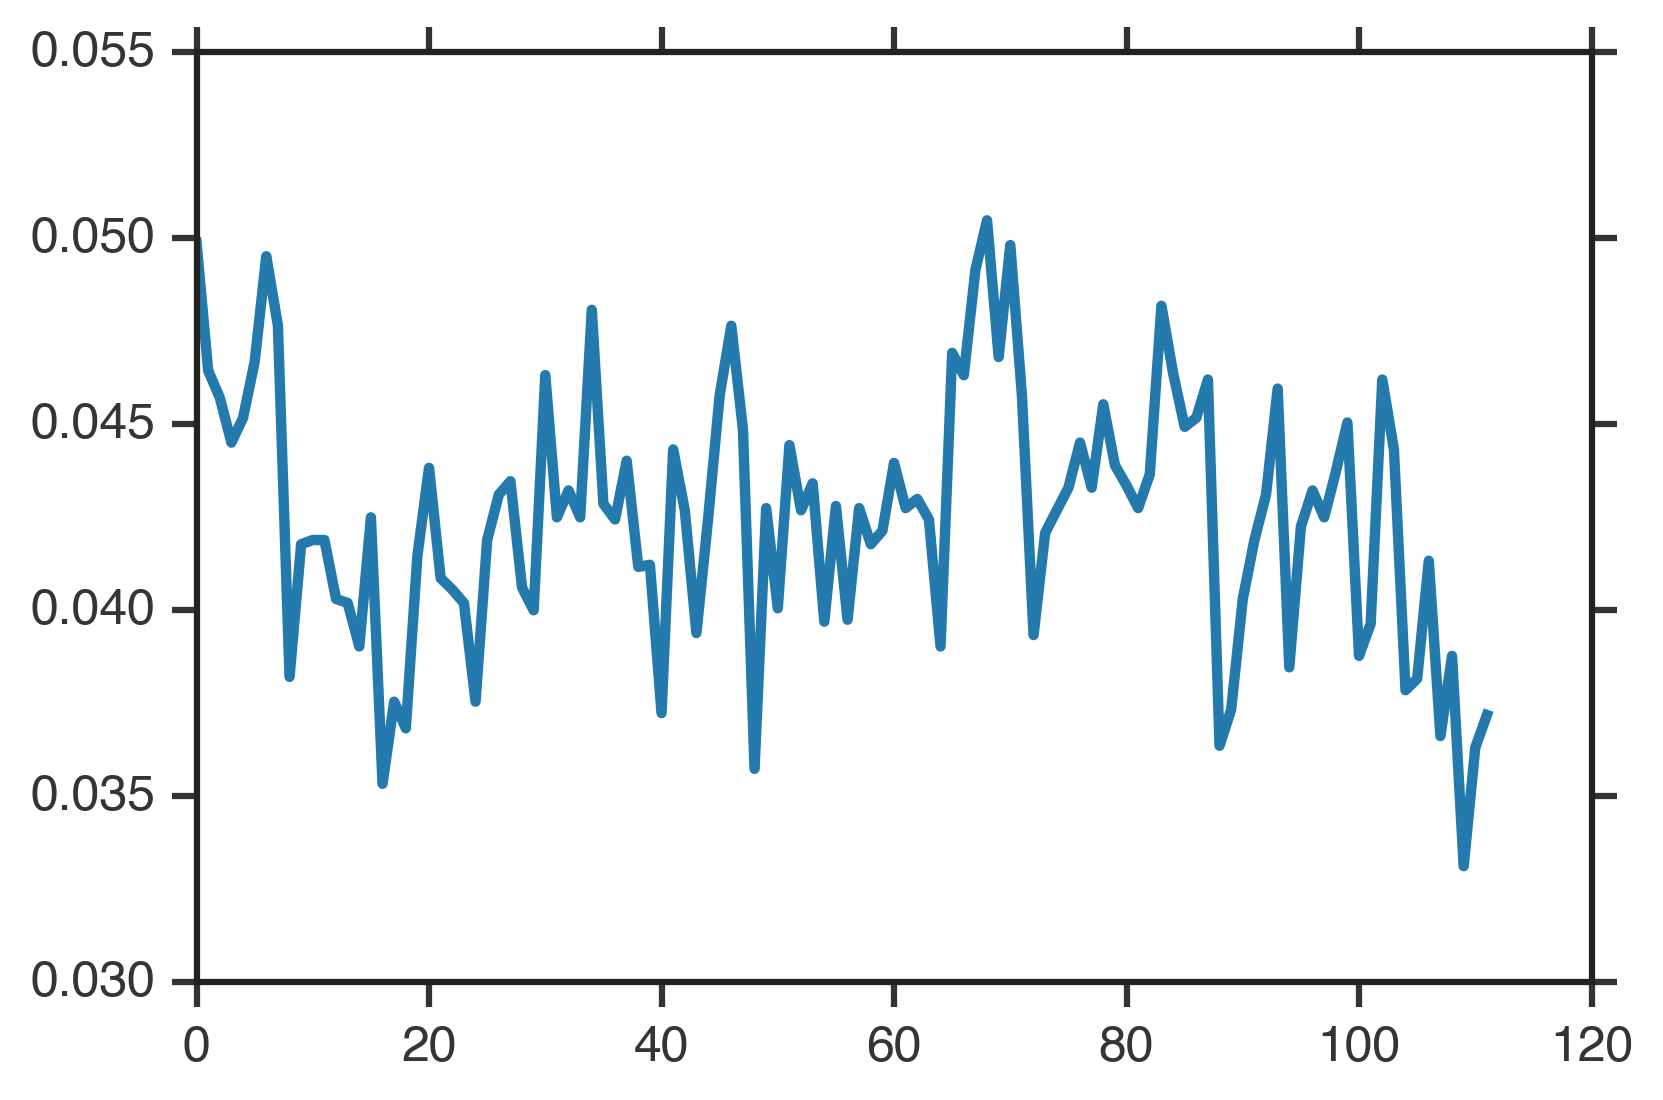

In [51]:
plt.plot(signal_across_time)

In [52]:
psth_variability_across_time

0.011175918202246466

In [53]:
np.nanmean(snrs_using_residuals)

1.2695921563886901